In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # "gpu" or "cpu"
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from dataclasses import dataclass
import matplotlib.pyplot as plt
import scipy.optimize as sciopt
import scipy.integrate as sciint
import h5py
import pathlib as path
import numpy as np

from tqdm import tqdm
import time
import functools as ft
maindir = path.Path("C:/Users/nickd/PyFluid")
gifdir   = maindir / "gifs"
exactdir = maindir / "exact_balsara"
checkdir = maindir / "checkpoints"
print(jax.devices("cpu"))
print(jax.devices("gpu"))
print(f'Using jax device {jax.devices()}')

[CpuDevice(id=0)]
[CudaDevice(id=0)]
Using jax device [CpuDevice(id=0)]


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1064.63it/s]

Main Run Done.


Final Step 75, Final Time = 0.4356, Mean dt = 5.80762e-03
Avg. Cell Updates /s = 2.606709e+05
Allocate Time = 2.0593 s, Compile Time = 0.6148 s
Runtime = 0.0737 s, Total Time = 2.7478 s


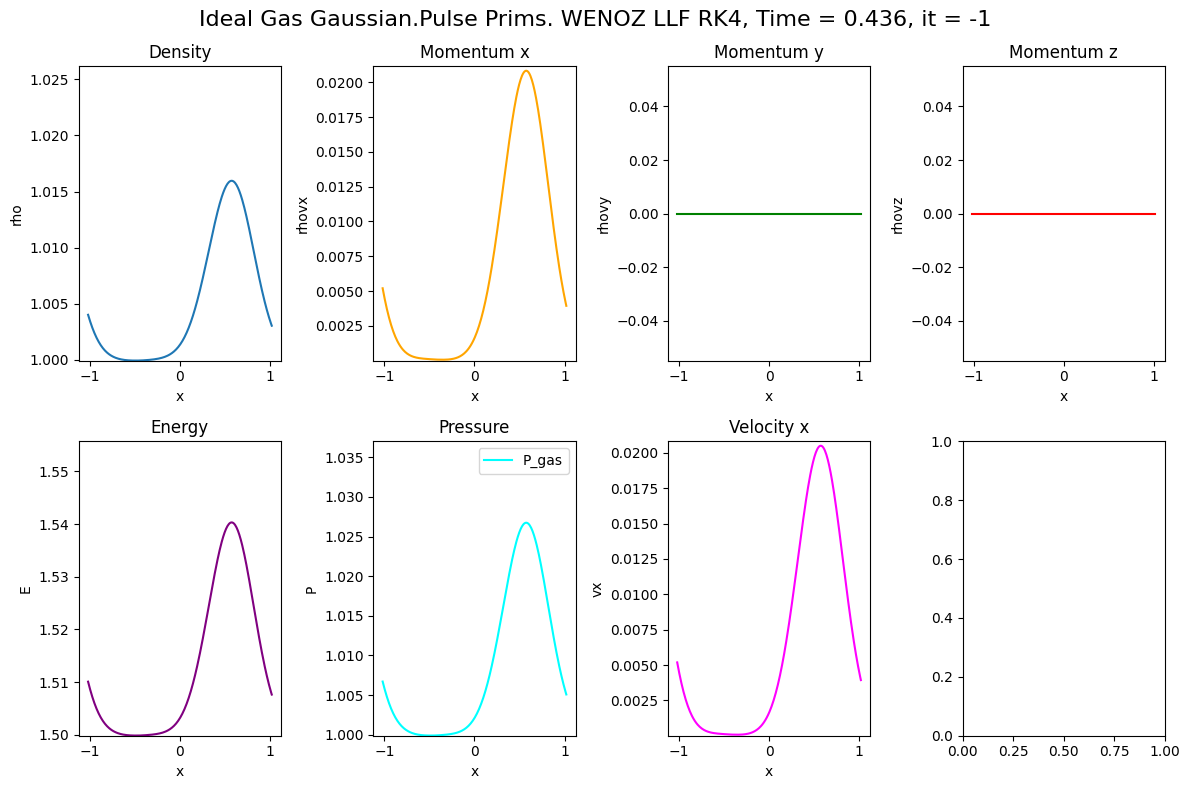

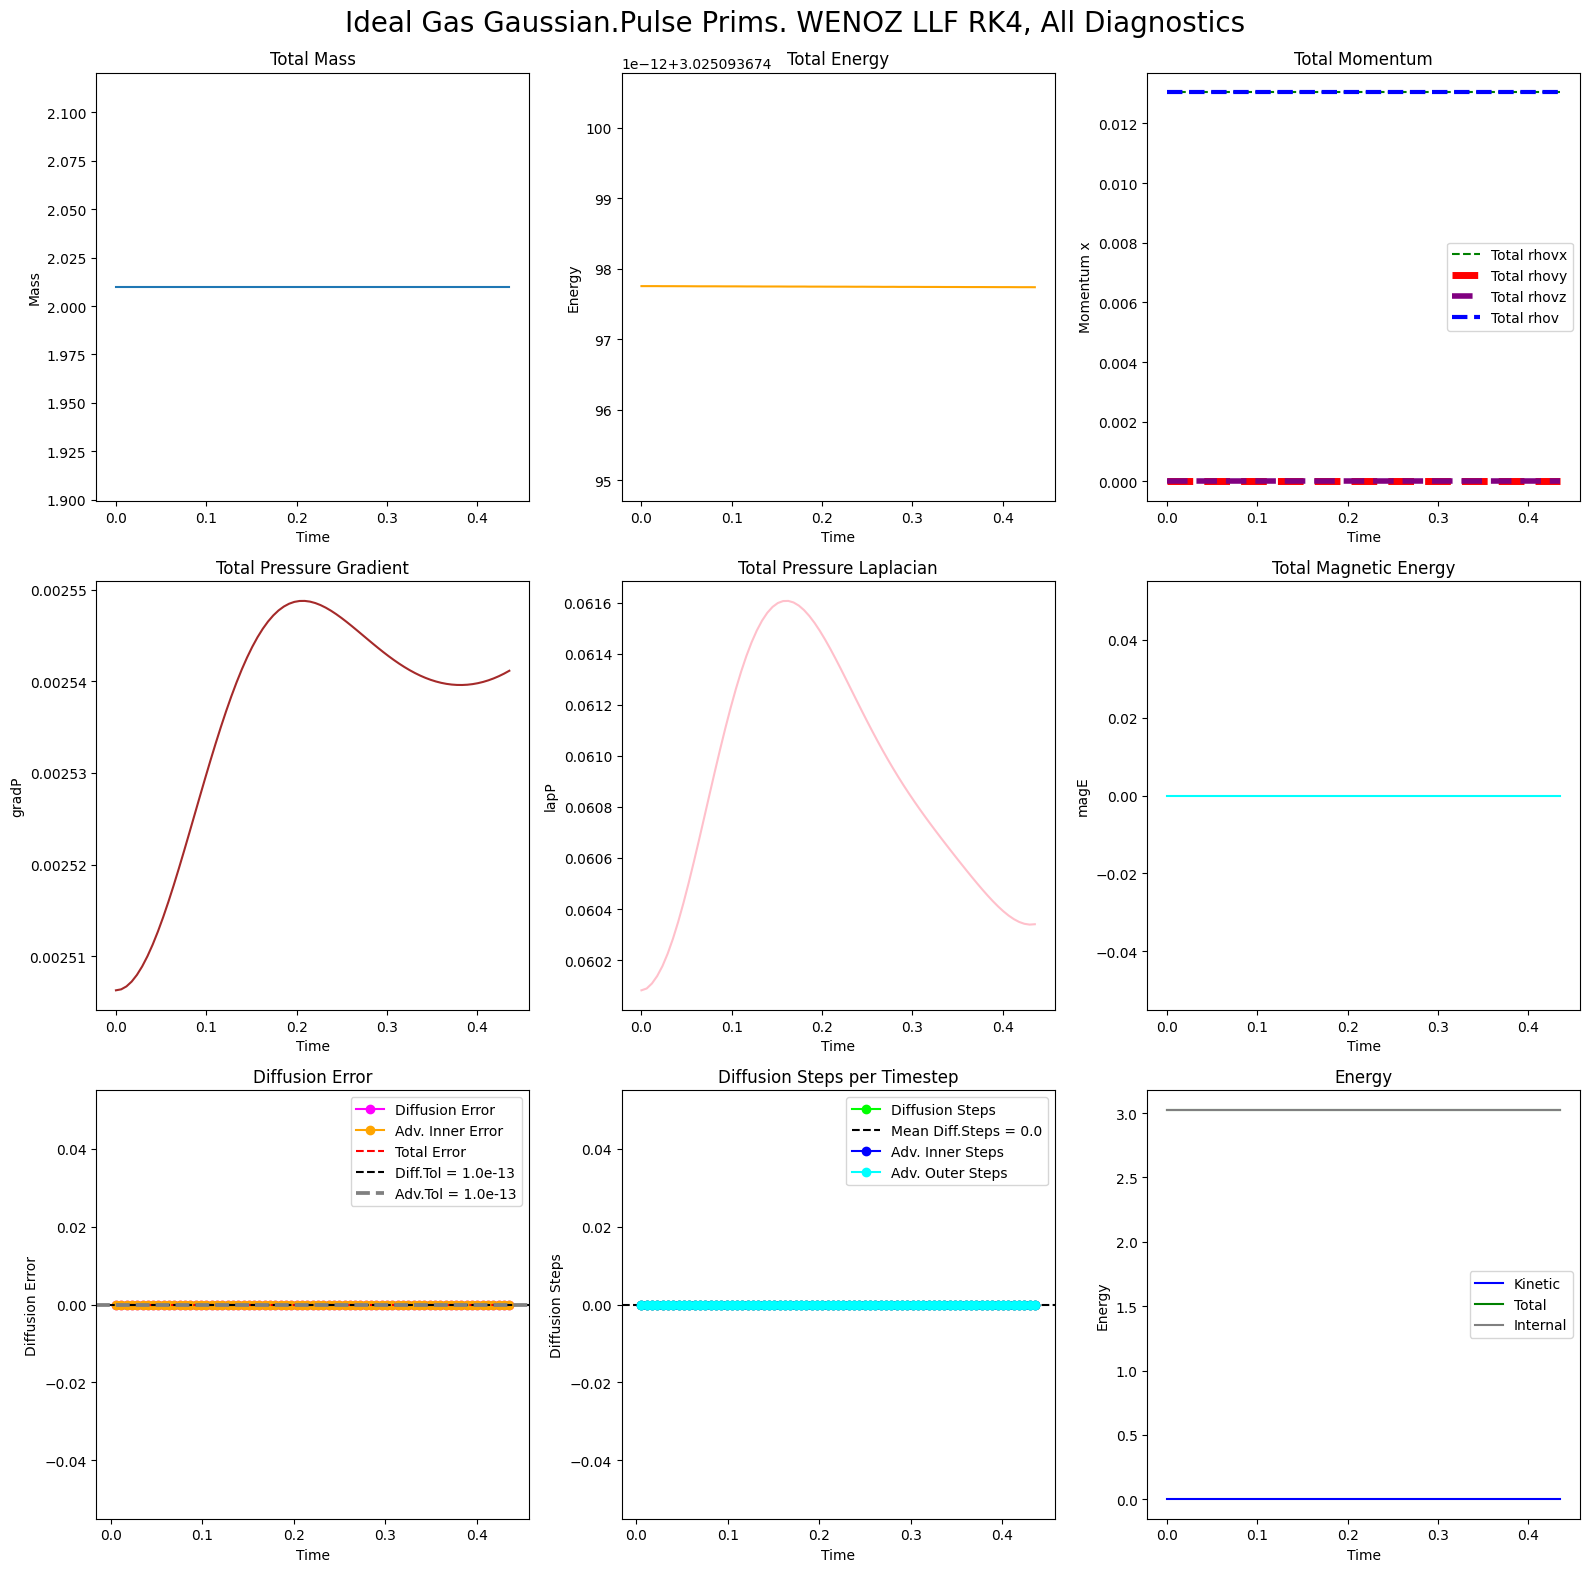

In [ ]:
cl = 1.0 #speed of light in code units
cl2 = cl*cl;
#1 Dimension MHD, Compressible, Adiabatic, Viscous, Resistive, Finite Volume.
@jax.jit
def calc_sloplim_diff(a,b):
   return (a + b)/2

@jax.jit
def calc_sloplim_minmod(a,b):
   return(jnp.where(jnp.sign(a) == jnp.sign(b), jnp.where(jnp.abs(a) < jnp.abs(b), a, b), 0.0))

@jax.jit
def calc_sloplim_superbee(a,b):
   return jnp.maximum(0,jnp.minimum(2*jnp.abs(a),jnp.abs(b)),jnp.minimum(jnp.abs(a),2*jnp.abs(b))) \
                  *jnp.sign(a)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0)
   
@jax.jit
def calc_sloplim_vanleer(a,b):
   out = (2*a*b)/(a+b + 1e-16)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0)
   out = jnp.where(out >=1e15, 0.0, out) #handle inf/nan cases
   return(out)

@jax.jit
def calc_sloplim_mc(a,b):
   return jnp.minimum(0.5*(a+b),2*jnp.abs(a),2*jnp.abs(b))*jnp.sign(a)*jnp.where(jnp.sign(a) == jnp.sign(b),1.0,0.0)

def calc_v4(p3f,selff):
   return (p3f - selff.presR)*np.sqrt((1 - selff.gammaex)/(selff.rhoR*(p3f + selff.gammaex*selff.presR)))

def calc_v3(p3f,selff):
   return ((selff.presL**selff.betaex) - (p3f**selff.betaex))*np.sqrt(((1 - selff.gammaex**2)*(selff.presL**(1/selff.gamma))/((selff.gammaex**2)*selff.rhoL)))

def calc_root_pres3(p3f,selff):
   return(calc_v3(p3f,selff) - calc_v4(p3f,selff))

def soft_dict_equal(a, b, tol=1e-12, exclude=None):
    """
    Compare two dictionaries that may contain arrays, floats, strings, bools.
    Prints mismatches and returns True if equal (within tolerance).

    exclude: iterable of keys to ignore during comparison.
    """
    same = True
    exclude = set(exclude or [])  # convert to set for fast lookup

    # 1. Check for missing or extra keys
    a_keys, b_keys = set(a.keys()), set(b.keys())
    if a_keys != b_keys:
        missing_in_a = b_keys - a_keys
        missing_in_b = a_keys - b_keys
        if missing_in_a:
            print(f"⚠️ Missing in first dict: {missing_in_a}")
        if missing_in_b:
            print(f"⚠️ Missing in second dict: {missing_in_b}")
        same = False

    # 2. Compare values for common keys
    for k in a_keys & b_keys:
        if k in exclude:
            continue  # skip excluded keys

        v1, v2 = a[k], b[k]

        if isinstance(v1, jnp.ndarray) and isinstance(v2, jnp.ndarray):
            if not jnp.allclose(v1, v2, rtol=tol, atol=tol):
                print(f"⚠️ Array mismatch for key '{k}':")
                print(f"   First:  {v1}")
                print(f"   Second: {v2}")
                same = False

        elif isinstance(v1, (float, jnp.floating)) and isinstance(v2, (float, jnp.floating)):
            if not jnp.isclose(v1, v2, rtol=tol, atol=tol):
                print(f"⚠️ Float mismatch for key '{k}': {v1} vs {v2}")
                same = False

        elif isinstance(v1, (int, bool, str)) and isinstance(v2, (int, bool, str)):
            if v1 != v2:
                print(f"⚠️ Value mismatch for key '{k}': {v1} vs {v2}")
                same = False

        else:
            # fallback for mismatched types
            if v1 != v2:
                print(f"⚠️ Type or value mismatch for key '{k}': {v1} ({type(v1)}) vs {v2} ({type(v2)})")
                same = False

    return same

class PhysicsBase:
   @dataclass(frozen=True)
   class PhysicsModel:
         gamma: float
         kappa: float
         cs20: float
         boolmag: bool
         voi: int
         diffparams: tuple
         diffloopparams: tuple
         booldiff: bool
         impadv: bool
         EOS_P: callable
         EOS_eps: callable
         EOS_cs2: callable
         calc_energy: callable
         calc_eps: callable
         
         con2prim: callable
         prim2con: callable
         calc_anfluxes: callable
         calc_anfluxes_diff: callable
   def __init__(self,parent):
      self.parent = parent
      self.reli = parent.reli
      self.eosi = parent.eosi

      if self.eosi == 0: #Isothermal
         self.EOS_P = self.EOS_P_iso
         self.EOS_cs2 = self.EOS_cs2_iso
         self.EOSname = "Isotherm."
      if self.eosi == 1: #Ideal Gas
         self.EOS_P = self.EOS_P_ideal
         self.EOS_cs2 = self.EOS_cs2_idpoly
         self.EOSname = "Ideal Gas"
      if self.eosi == 2: #Polytrope
         self.EOS_P = self.EOS_P_polytrope
         self.EOS_cs2 = self.EOS_cs2_idpoly
         self.EOSname = "Polytrope"
      if self.eosi in [0,1,2]:
         self.EOS_eps = self.EOS_eps_isoidpoly
      if self.eosi not in [0,1,2]:
         raise ValueError("Equation of State not recognized.")
      if self.reli == 0: #Non-Relativistic
         self.calc_energy = self.calc_energy_NR
         self.calc_eps = self.calc_eps_NR
         self.con2prim = self.con2prim_NR
         self.prim2con = self.prim2con_NR
         self.calc_anfluxes = self.calc_anfluxes_NR
         self.calc_anfluxes_diff = self.calc_anfluxes_diff_NR
         self.relname = "Non-Rel."
      elif self.reli == 1: #Special Relativistic
         self.con2prim = self.con2prim_SR
         self.prim2con = self.prim2con_SR
         self.calc_anfluxes = self.calc_anfluxes_SR
         self.relname = "Spec.Rel."
      
   
   def init_diffpars(self):
      self.nu = self.parent.dx*float(jnp.sqrt(self.parent.cs20)) #kinematic viscosity coefficient
      self.mu = self.nu*self.parent.rhob #dynamic viscosity coefficient
      self.lam = -(2/3)*self.mu #second viscosity coefficient
      self.eta = 1e-4 #resistivity coefficient
      self.diffparams = tuple([self.nu,self.mu,self.lam,self.eta])
      self.diffloopparams = tuple([self.parent.difftol, self.parent.diffstepmax])

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def EOS_cs2_iso(rhof,presf,physicsmodelf = None):
      return(presf/rhof)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def EOS_cs2_idpoly(rhof,presf,physicsmodelf):
      return(physicsmodelf.gamma*presf/rhof)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def EOS_P_iso(rho,emd,physicsmodelf):
      return(physicsmodelf.cs20*rho)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def EOS_P_ideal(rho,emd,physicsmodelf):
      return((physicsmodelf.gamma - 1.0)*rho*emd)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def EOS_P_polytrope(rhof,emd,physicsmodelf):
      return(physicsmodelf.kappa*(rhof**physicsmodelf.gamma))
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def EOS_eps_isoidpoly(Pf,physicsmodelf):
      return(Pf/(physicsmodelf.gamma - 1.0))

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def calc_speeds(pvecf, physicsmodelf):
      #Calc wave speeds (cs2,cs2Ax,cs2A,cs2f)
      cs2out = jnp.zeros((4,pvecf.shape[1]))
      cs2out = cs2out.at[0,:].set(physicsmodelf.EOS_cs2(pvecf[0,:],pvecf[4,:],physicsmodelf)) #sound speed squared
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[1,:].set(jnp.square(pvecf[5,:])/pvecf[0,:]), lambda x: x.at[1,:].set(0),cs2out)
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[2,:].set((jnp.square(pvecf[5:8,:])).sum(axis=0)/pvecf[0,:]), lambda x: x.at[2,:].set(0),cs2out)
      cs2out = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[3,:].set(0.5*(cs2out[0,:] + cs2out[2,:] \
                     + jnp.sqrt((cs2out[0,:] + cs2out[2,:])**2 - 4*cs2out[0,:]*cs2out[1,:]))), lambda x: x.at[3,:].set(cs2out[0,:]),cs2out)
      return(cs2out)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def con2prim_NR(uvecf, physicsmodelf):
      #print(np.min(uvecf[0,:]))
      rhoinv = 1.0/uvecf[0,:];
      pvecout = jnp.zeros_like(uvecf)
      pvecout = pvecout.at[0,:].set(uvecf[0,:]) #density
      pvecout = pvecout.at[1:4,:].set(uvecf[1:4,:]*rhoinv) #velocities
      eps = physicsmodelf.calc_eps(uvecf, physicsmodelf)
      pvecout = pvecout.at[4,:].set(physicsmodelf.EOS_P(uvecf[0,:], eps*rhoinv,physicsmodelf))
      pvecout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[5:8,:].set(uvecf[5:8,:]), lambda x: x, pvecout)
      return(pvecout)
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def prim2con_NR(pvecf, physicsmodelf):
      uvecout = jnp.zeros_like(pvecf)
      uvecout = uvecout.at[0,:].set(pvecf[0,:]) #density
      uvecout = uvecout.at[1:4,:].set(pvecf[0,:]*pvecf[1:4,:]) #momentum
      uvecout = uvecout.at[4,:].set(physicsmodelf.calc_energy(pvecf, physicsmodelf))
      uvecout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x.at[5:8,:].set(pvecf[5:8,:]), lambda x: x, uvecout)
      return(uvecout)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def calc_energy_NR(pvecf, physicsmodelf):
      Energyout = physicsmodelf.EOS_eps(pvecf[4,:],physicsmodelf) + 0.5*pvecf[0,:]*jnp.square(pvecf[1:4,:]).sum(axis=0)
      Energyout = jax.lax.cond(physicsmodelf.boolmag, lambda x: x + 0.5*jnp.square(pvecf[5:8,:]).sum(axis=0), lambda x: x, Energyout)
      return Energyout

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def calc_eps_NR(uvecf, physicsmodelf):
      eps = (uvecf[4,:] - 0.5*jnp.square(uvecf[1:4,:]).sum(axis=0)/uvecf[0,:] ) #internal energy
      eps = jax.lax.cond(physicsmodelf.boolmag, lambda x: x - 0.5*jnp.square(uvecf[5:8,:]).sum(axis=0), lambda x: x, eps)
      return(eps)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,))
   def calc_anfluxes_NR(uvecf, pvecf, physicsmodelf):
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[0,:].set(uvecf[1,:]) #mass flux
      fluxvecf = fluxvecf.at[1:4,:].set(uvecf[1,None,:]*pvecf[1:4,:] +jnp.outer( jnp.eye(3)[0],pvecf[4,:]) ) #momentum flux
      fluxvecf = fluxvecf.at[4,:].set((uvecf[4,:] + pvecf[4,:] )*pvecf[1,:])   #energy flux
      if physicsmodelf.boolmag:
         metot = 0.5*jnp.square(pvecf[5:8,:]).sum(axis=0)
         fluxvecf = fluxvecf.at[1:4,:].add(-pvecf[5,None,:]*pvecf[5:8,:]) #momentum flux
         fluxvecf = fluxvecf.at[1,:].add(metot)
         fluxvecf = fluxvecf.at[4,:].add(metot*pvecf[1,:] - pvecf[5,:]*jnp.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0)) #energy flux correction
         fluxvecf = fluxvecf.at[5,:].set(0.0)
         fluxvecf = fluxvecf.at[6:8,:].set( pvecf[6:8,:]*pvecf[1,:] - pvecf[5,None,:]*pvecf[2:4,:]) #By,Bz flux
      return(fluxvecf)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3))
   def calc_anfluxes_diff_NR(uvecf,pvecf, gridparamsf,physicsmodelf):
      stress, dx_stress = PhysicsBase.calc_stressdivstress_NR(pvecf, gridparamsf, physicsmodelf);
      imask = slice(gridparamsf.ng,-gridparamsf.ng)
      fluxvecf = jnp.zeros_like(uvecf)
      fluxvecf = fluxvecf.at[1:4,imask].set(-dx_stress[:,imask]);
      fluxvecf = fluxvecf.at[4,imask].set(-jnp.gradient(stress[0,:]*pvecf[1,:],gridparamsf.dx)[imask])
      if physicsmodelf.boolmag:
         eta = physicsmodelf.diffparams[3]
         fluxvecf = fluxvecf.at[4,imask].add(-eta*jnp.square(jnp.gradient(pvecf[5:8,:],gridparamsf.dx,axis=1)).sum(axis=0)[imask]) #resistive heating
         fluxvecf = fluxvecf.at[5:8,imask].set(-eta*jnp.gradient(jnp.gradient(pvecf[5:8,:],gridparamsf.dx,axis=1),gridparamsf.dx,axis=1)[:,imask])
      return(fluxvecf)

   @staticmethod #tuple([self.nu,self.mu,self.lam,self.eta])
   @ft.partial(jax.jit, static_argnums=(1,2))
   def calc_stressdivstress_NR(pvecf,gridparamsf,physicsmodelf):
      stressf = physicsmodelf.diffparams[1]*jnp.gradient(pvecf[1:4,:],gridparamsf.dx,axis=1) #stress tensor
      stressf = stressf.at[0,:].set(stressf[0,:] + (physicsmodelf.diffparams[2])*jnp.gradient(pvecf[1:4,:],gridparamsf.dx,axis=1).sum(axis=0)) #add normal stress to t_xx
      divstressf = jnp.gradient(stressf,gridparamsf.dx,axis=1) #divergence of stress tensor
      return stressf, divstressf

   def calc_lorentz_v2(self,v2f):
      return(1/np.sqrt(1 - (v2f/cl2)))
   
   def calc_lorentz_vec(self,vvecf):
      return(self.calc_lorentz_v2(np.square(vvecf).sum(axis=0)))

   def calc_hf(self,pvecf):
      eps = self.EOS_eps(pvecf[4,:])
      hf = 1 + (eps+ pvecf[4,:])/pvecf[0,:]
      return hf

   def calc_b2invariant_prim(self,pvecf):
      #print(np.min(pvecf[8,:]),self.parent.step)
      return(np.square(pvecf[5:8,:]/pvecf[8,:]).sum(axis=0) + (np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0)**2)/cl2)
   
   def calc_b2invariant_con(self,wf,zf,j):
      return(self.b2[j]/(wf**2) + (self.sdotb[j]**2)*(cl2)/(zf**2));

   def c2p_constraint2D_SR(self,uvecf,v2f,Pf,j):
      wt = self.calc_lorentz_v2(v2f);
      rhot = uvecf[0,j]/ wt;
      epst = self.EOS_eps(Pf)/rhot;
      ht = 1 + epst + Pf/rhot;
      Zt = uvecf[0,j]*ht*wt;
      b2invt = self.calc_b2invariant_con(wt,Zt,j);
      zpb22 = (Zt + b2invt)**2;
      f1 = (zpb22*v2f)/cl2 - (self.s2[j] + ((self.sdotb[j])**2)*(2*Zt + b2invt + self.b2[j])/(zpb22) )
      f2 = Zt - uvecf[0,j]*cl2 - (uvecf[4,j] + Pf + self.b2[j]/2.0)
      return(np.array([f1,f2]))

   def c2p_constraint1D_SR(self,uvecf,WCF,j):
      v2w = (self.s2[j] + (self.sdotb[j]**2)*(2*WCF + self.b2[j])/(WCF**2)) / (WCF + self.b2[j])**2
      Wf = self.calc_lorentz_v2(v2w)
      rhof = uvecf[0,j]/Wf
      hf = WCF/ (uvecf[0,j]*Wf)
      if self.eosi in [0,1]: #ideal gas
         epsf = (hf - 1)/ self.gamma
      elif self.eosi == 2: #polytrope
         epsf = hf - 1 - self.EOS_P(rhof,0)/rhof
      presf = self.EOS_P(rhof, epsf);
      return(WCF - presf - uvecf[0,j]*cl2 - uvecf[4,j])

   def con2prim_SR(self,uvecf,pvecout):
      pvecout[5:8,:] = uvecf[5:8,:] #magnetic fields
      self.s2 = np.square(uvecf[1:4,:]).sum(axis=0);
      self.b2 = np.square(uvecf[5:8,:]).sum(axis=0);
      self.d2 = np.square(uvecf[0,:])
      self.sdotb = np.sum(uvecf[1:4,:]*uvecf[5:8,:],axis=0);
      Wguess = np.sqrt(1 + self.s2/self.d2); vguess = np.sqrt(1 - 1/(Wguess**2))*cl;
      Pguess = (self.gamma - 1.0)*(uvecf[4,:] - self.s2/(2*uvecf[0,:]) - self.b2/2.0);
      WCFguess = np.sqrt(self.s2 + self.d2 + self.b2 + (self.sdotb**2)/self.d2);
      f0 = lambda rvec,j: self.c2p_constraint1D_SR(uvecf,rvec[0],j)
      f1 = lambda rvec,j: self.c2p_constraint2D_SR(uvecf,rvec[0],rvec[1],j)
      for j in range(len(uvecf[0,:])):
         #1D root find for WCF
         sol1d = sciopt.root(f0,(WCFguess[j]),args = (j), tol =1e-12)
         if sol1d.success:
            #print(f"1D root find success at j = {j}, step = {self.parent.step}")
            WCFres = sol1d.x[0];
            v2res = (self.s2[j] + (self.sdotb[j]**2)*(2*WCFres + self.b2[j])/(WCFres**2)) / (WCFres + self.b2[j])**2;
            Wres = self.calc_lorentz_v2(v2res); rhores = uvecf[0,j]/Wres;
            hf = WCFres/ (uvecf[0,j]*Wres)
            if self.eosi in [0,1]: #ideal gas
               epsf = (hf - 1)/ self.gamma
            elif self.eosi == 2: #polytrope
               epsf = hf - 1 - self.EOS_P(rhores,0)/rhores
            Pres = self.EOS_P(uvecf[0,j], epsf);
         if not sol1d.success:
            #print(f"Warning: 1D root find failed at j = {j}, step = {self.parent.step}")
            #print(f"Trying 2D root find")
            sol2d = sciopt.root(f1,(vguess[j],Pguess[j]),args = (j))

            v2res = sol2d.x[0]; Pres = sol2d.x[1]; Wres = self.calc_lorentz_v2(v2res);
            rhores = uvecf[0,j]/Wres;
         
         pvecout[0,j] = rhores
         pvecout[4,j] = Pres
         hfres = self.calc_hf(pvecout[:,j,np.newaxis])
         Zres = uvecf[0,j]*hfres*Wres
         b2invres = self.calc_b2invariant_con(Wres,Zres,j)
         
         
         denom = Zres + b2invres
         numerator = uvecf[1:4,j] + (self.sdotb[j] * uvecf[5:8,j])/(denom*cl2)
         pvecout[1:4,j] = (numerator/denom)
         pvecout[8,j] = Wres

   def prim2con_SR(self,pvecf,uvecout):
      b2inv = self.calc_b2invariant_prim(pvecf)
      hf = self.calc_hf(pvecf)
      htot = hf + b2inv/pvecf[0,:];
      pW = pvecf[0,:]*pvecf[8,:] #rho*W
      uvecout[0,:]   = pW #conserved density D
      uvecout[1:4,:] = pW*pvecf[8,:]*htot*pvecf[1:4,:]/cl2 \
                 - (pvecf[5:8,:]*np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0))/cl2 #conserved momentum S
      uvecout[4,:]   = pW*(pvecf[8,:]*htot - cl2) - pvecf[4,:] - b2inv/2.0  
      uvecout[5:8,:] = pvecf[5:8,:] #magnetic fields
   
   def calc_anfluxes_SR(self,uvecf, pvecf, fluxvecf):
      metot = 0.5*np.square(pvecf[5:8,:]).sum(axis=0);
      hf = self.calc_hf(pvecf); pW = pvecf[0,:]*pvecf[8,:]; pW2 = pW*pvecf[8,:];phW2 = hf*pW2;
      fluxvecf[0,:] = pW*pvecf[1,:]; #mass flux
      fluxvecf[1:4,:] = phW2 * pvecf[1:4,:]*pvecf[1,:] - pvecf[5,np.newaxis,:]*pvecf[5:8,:] #momentum flux
      fluxvecf[1,:] += pvecf[4,:] + metot #corrections to x flux
      fluxvecf[4,:] = (phW2 * pvecf[1,:] - pvecf[4,:])*pvecf[1,:] - pvecf[5,:] * np.sum(pvecf[5:8,:]*pvecf[1:4,:],axis=0)
      fluxvecf[5,:] = 0.0
      fluxvecf[6:8,:] = pvecf[1,:] * pvecf[6:8,:] - pvecf[5,:]*pvecf[2:4,:] #By,Bz flux

class ReconBase:
   @dataclass(frozen=True)
   class ReconModel:
      LRreconV: callable
      LRrecon_UP: callable
      calc_slopelimit: callable
      wenoweights: tuple
      weno_eps: float
   def __init__(self,parent):
      self.parent = parent
      self.ng = parent.ng; self.ngi = parent.ngi; self.ngnet = self.ng - self.ngi
      self.nx = parent.nx
      self.limi = parent.limi
      self.reconi = parent.reconi
      norm= 10.0
      self.wenoweights = tuple(x/norm for x in (3.0, 6.0, 1.0))
      self.weno_eps = 1e-8

      self.outer0 = -self.ngnet if self.ngnet >= 1 else None
      self.outeri1 = -(self.ngnet - 1) if self.ngnet >= 2 else None
      self.outeri2 = -(self.ngnet - 2) if self.ngnet >= 3 else None
      self.outeri3 = -(self.ngnet - 3) if self.ngnet >= 4 else None
      #print(self.outer0,self.outeri1,self.outeri2,self.outeri3)
     
      if self.limi == 0:
         self.calc_slopelimit = calc_sloplim_diff
         self.limname = "Cen.Diff."
      elif self.limi == 1:
         self.calc_slopelimit = calc_sloplim_minmod
         self.limname = "MinMod"
      elif self.limi == 2:
         self.calc_slopelimit = calc_sloplim_superbee
         self.limname = "Superbee"
      elif self.limi == 3:
         self.calc_slopelimit = calc_sloplim_vanleer       
         self.limname = "VanLeer"
      elif self.limi == 4:
         self.calc_slopelimit = calc_sloplim_mc
         self.limname = "MC"
      elif self.limi not in [0,1,2,3,4]:
         raise ValueError("Slope limiter not recognized.")
      if self.reconi == 0:
         self.LRreconV = self.LRreconV_pwconstant
         self.reconname = "PW.Constant"
         self.reconnames = self.reconname
         assert(self.ng-self.ngi >= 1)
      if self.reconi == 1:
         self.LRreconV = self.LRreconV_pwlinear_slopelimited
         self.reconname = "PW.Linear"
         self.reconnames = self.reconname + " " + self.limname
         assert(self.ng-self.ngi >= 2)
      if self.reconi == 2:
         self.LRreconV = self.LRreconV_wenoz
         self.reconname = "WENOZ"
         self.reconnames = self.reconname
         assert(self.ng-self.ngi >= 3)
      elif self.reconi not in [0,1,2]:
         raise ValueError("Reconstruction method not recognized.")


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3))
   def LRreconV_pwconstant(vvecf, gridparamsf, physicsmodelf, reconmodelf = None):
      #Piecewise constant reconstruction
      sl = physicsmodelf.voi
      vvecintLf = jnp.zeros((8, gridparamsf.nxifs))
      vvecintRf = jnp.zeros((8, gridparamsf.nxifs))
      vvecintLf = vvecintLf.at[0:sl,:].set(vvecf[0:sl, gridparamsf.ngnet-1:gridparamsf.outer0])
      vvecintRf = vvecintRf.at[0:sl,:].set(vvecf[0:sl, gridparamsf.ngnet:gridparamsf.outer1])
      return vvecintLf, vvecintRf

   #@nb.njit(inline='always')
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3))
   def LRreconV_pwlinear_slopelimited(vvecf, gridparamsf, physicsmodelf, reconmodelf):
      ngn = gridparamsf.ngnet
      sl = physicsmodelf.voi
      vveccintLf = jnp.zeros((8, gridparamsf.nxifs))
      vveccintRf = jnp.zeros((8, gridparamsf.nxifs))
      dVvecL = vvecf[0:sl, ngn-1:gridparamsf.outer1]  - vvecf[0:sl, ngn-2:gridparamsf.outer0]
      dVvecR = vvecf[0:sl, ngn:gridparamsf.outer2]    - vvecf[0:sl, ngn-1:gridparamsf.outer1]

      dVveclim = reconmodelf.calc_slopelimit(dVvecL,dVvecR)
      vvecintLf = vveccintLf.at[0:sl, :].set(vvecf[0:sl, ngn-1:gridparamsf.outer0] + 0.5*dVveclim[:, 0:-1])
      vvecintRf = vveccintRf.at[0:sl, :].set(vvecf[0:sl, ngn:gridparamsf.outer1]   - 0.5*dVveclim[:, 1:])
      return vvecintLf, vvecintRf


   #@nb.njit(inline='always')
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3))
   def LRreconV_wenoz(vvecf, gridparamsf, physicsmodelf, reconmodelf):
      sl = physicsmodelf.voi
      ngn = gridparamsf.ngnet
      vveccintLf = jnp.zeros((8, gridparamsf.nxifs))
      vveccintRf = jnp.zeros((8, gridparamsf.nxifs))
      #print(ngn)
      gf_Imm = vvecf[0:sl, ngn-3:-(ngn+1)]  # v_{i-3}       
      gf_Im  = vvecf[0:sl, ngn-2:gridparamsf.outer0]   # v_{i-2}
      gf_I   = vvecf[0:sl, ngn-1:gridparamsf.outer1]
      gf_Ip  = vvecf[0:sl, ngn:gridparamsf.outer2]     # v_{i+1}
      gf_Ipp = vvecf[0:sl, ngn+1:gridparamsf.outer3]  # v_{i+2}
      #print(gf_Imm.shape,gf_Im.shape,gf_I.shape,gf_Ip.shape,gf_Ipp.shape)

 
      omegaZ0m, omegaZ1m, omegaZ2m, omegaZ0p, omegaZ1p, omegaZ2p = ReconBase.calc_weno_omegas(reconmodelf, gf_Imm,gf_Im,gf_I,gf_Ip,gf_Ipp)

      Rres = ((omegaZ2m / 6.0) * (2.0 * gf_Ipp - 7.0 * gf_Ip + 11.0 * gf_I) +\
                        (omegaZ1m / 6.0) * (-1.0 * gf_Ip + 5.0 * gf_I + 2.0 * gf_Im)  +\
                        (omegaZ0m / 6.0) * (2.0 * gf_I + 5.0 * gf_Im - 1.0 * gf_Imm))[:, 1:]
      Lres = ((omegaZ0p / 6.0) * (2.0 * gf_Imm - 7.0 * gf_Im + 11.0 * gf_I) +\
                        (omegaZ1p / 6.0) * (-1.0 * gf_Im + 5.0 * gf_I + 2.0 * gf_Ip) +\
                        (omegaZ2p / 6.0) * (2.0 * gf_I + 5.0 * gf_Ip - 1.0 * gf_Ipp))[:, :-1]
      
      vveccintLf = vveccintLf.at[0:sl, :].set(Lres)
      vveccintRf = vveccintRf.at[0:sl, :].set(Rres)
      return vveccintLf, vveccintRf

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_weno_omegas(reconmodelf,gf_Imm,gf_Im,gf_I,gf_Ip,gf_Ipp):
      betaZ0 = (13/12) * (gf_Imm - 2*gf_Im + gf_I)**2 \
         + (1/4) * (gf_Imm - 4*gf_Im + 3*gf_I)**2
      betaZ1 = (13/12) * (gf_Im - 2*gf_I + gf_Ip)**2 \
         + (1/4) * (gf_Im - gf_Ip)**2
      betaZ2  = (13/12) * (gf_I - 2*gf_Ip + gf_Ipp)**2 \
         + (1/4) * (3*gf_I - 4*gf_Ip + gf_Ipp)**2
      tau5 = jnp.abs(betaZ0 - betaZ2)
      aux_alphaZ0 = 1.0 + tau5 /  (reconmodelf.weno_eps + betaZ0)
      aux_alphaZ1 = 6.0 + tau5 /  (reconmodelf.weno_eps + betaZ1)
      aux_alphaZ2 = 3.0 + tau5 /  (reconmodelf.weno_eps + betaZ2)
      alphaZ0m = aux_alphaZ0 * reconmodelf.wenoweights[0]
      alphaZ1m = aux_alphaZ1 * reconmodelf.wenoweights[1]
      alphaZ2m = aux_alphaZ2 * reconmodelf.wenoweights[2]
      alphaZ0p = aux_alphaZ0 * reconmodelf.wenoweights[2]
      alphaZ1p = aux_alphaZ1 * reconmodelf.wenoweights[1]
      alphaZ2p = aux_alphaZ2 * reconmodelf.wenoweights[0]
      sum_alphaZm = alphaZ0m + alphaZ1m + alphaZ2m
      sum_alphaZp = alphaZ0p + alphaZ1p + alphaZ2p
      omegaZ0m = alphaZ0m / sum_alphaZm
      omegaZ1m = alphaZ1m / sum_alphaZm   
      omegaZ2m = alphaZ2m / sum_alphaZm
      omegaZ0p = alphaZ0p / sum_alphaZp
      omegaZ1p = alphaZ1p / sum_alphaZp
      omegaZ2p = alphaZ2p / sum_alphaZp
      return(omegaZ0m, omegaZ1m, omegaZ2m, omegaZ0p, omegaZ1p, omegaZ2p)

class BoundaryConditionBase:
   @dataclass(frozen=True)
   class BCModel:
      lhgtupF : tuple
      rhgtupF : tuple
      lhitupF : tuple
      rhitupF : tuple
      ng : int

      bcLfunc : callable
      bcRfunc : callable
   def __init__(self,parent):
      self.parent = parent
      self.ng = parent.ng
      self.lhgslF = parent.lhgslF
      self.lhislF = parent.lhislF
      self.rhgslF = parent.rhgslF
      self.rhislF = parent.rhislF
      self.bci = parent.bci

      assert(len(self.bci) == 2)

      BC_L_List = [self.periodic_L, self.outflow_L, self.reflective_L]
      BC_R_List = [self.periodic_R, self.outflow_R, self.reflective_R]
      self.bcLfunc = BC_L_List[self.bci[0]]
      self.bcRfunc = BC_R_List[self.bci[1]]
      if self.bci[0] not in [0,1,2] or self.bci[1] not in [0,1,2]:
         raise ValueError("Boundary condition not recognized. Use 0 = periodic, 1 = outflow, 2 = reflective")
      
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1))
   def apply_bcs(pvecf,BCmodelf):
      pvecf = BCmodelf.bcLfunc(pvecf,BCmodelf)
      pvecf = BCmodelf.bcRfunc(pvecf,BCmodelf)
      return(pvecf)
      
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def periodic_L(pvecf, BCmodelf):
      return(pvecf.at[:,BCmodelf.lhgtupF[0]:BCmodelf.lhgtupF[1]].set(pvecf[:,BCmodelf.rhitupF[0]:BCmodelf.rhitupF[1]]))
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def periodic_R(pvecf, BCmodelf):
      return(pvecf.at[:,BCmodelf.rhgtupF[0]:BCmodelf.rhgtupF[1]].set(pvecf[:,BCmodelf.lhitupF[0]:BCmodelf.lhitupF[1]]))
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def outflow_L(pvecf, BCmodelf):
      return(pvecf.at[:,BCmodelf.lhgtupF[0]:BCmodelf.lhgtupF[1]].set(pvecf[:,BCmodelf.ng,jnp.newaxis]))
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def outflow_R(pvecf, BCmodelf):
      return(pvecf.at[:,BCmodelf.rhgtupF[0]:BCmodelf.rhgtupF[1]].set(pvecf[:,-BCmodelf.ng - 1,jnp.newaxis]))
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def reflective_L(pvecf, BCmodelf):  
      pvecf = pvecf.at[:,BCmodelf.lhgtupF[0]:BCmodelf.lhgtupF[1]].set(pvecf[:,BCmodelf.ng,jnp.newaxis])
      pvecf = pvecf.at[1,BCmodelf.lhgtupF[0]:BCmodelf.lhgtupF[1]].multiply(-1)
      return(pvecf)
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def reflective_R(pvecf, BCmodelf):
      pvecf = pvecf.at[:,BCmodelf.rhgtupF[0]:BCmodelf.rhgtupF[1]].set(pvecf[:,-BCmodelf.ng - 1,jnp.newaxis])
      pvecf = pvecf.at[1,BCmodelf.rhgtupF[0]:BCmodelf.rhgtupF[1]].multiply(-1)
      return(pvecf)
     

class Fluid1DMHD:
   def __init__(self, params):
      self.start_time0 = time.time()
      #Initialize the base grid, ghost cells and interior.
      self.pardict = params
      self.nsteps = int(params['Nsteps'])
      self.x0,self.x1 = params['x0'], params['x1']
      self.nx = int(params['nx'])
      self.ici = params['ici']; self.bci = params['bci']; self.reconi = params['reconi']; self.fluxi = params['fluxi'];
      self.timestepi = params['timestepi']; self.reconvari = params['reconvari'];
      self.eosi = params['eosi']; self.reli = params['reli']
      self.booldiff = params['booldiff']
      self.delrhofac = params['delrhofac']
      self.ng = int(params['ng']); self.ngi = int(params['ngi']);
      self.limi = params['limi']
      self.cflr = params['cfl']
      self.store_every = int(params['store_every'])
      self.checkname = params['checkname']; self.save_final_state = params['save_final_state']; self.recover_state = params['recover_state'];
      self.save_hdf5 = params['save_hdf5']
      self.gravpoti = params['gravpoti']; self.gravpoti_tp = params['gravpoti_tp']

      self.checkdirsim = checkdir / self.checkname;

      
      
      
      assert(self.reconvari in [0,1])
      if self.timestepi == 0 and self.reconi >=1:
         print(f"Warning: Euler Time step with Linear or better reconstruction can be unstable.")

      self.build_grid()
      assert(self.ng > self.ngi)
      self.outerd0 = - (self.ngi) if self.ngi >=1 else None
      self.intisl = slice(self.ngi, -self.ngi) if self.ngi >=1 else slice(0,None);

      
      
      self.gmask = jnp.zeros(self.nxtot, dtype=bool)
      self.gmask = self.gmask.at[:self.ng].set(True).at[-self.ng:].set(True)
      self.imask = ~self.gmask
      self.imasksl = slice(self.ng,-self.ng) #interior mask slice
      self.lhgslF = slice(0,self.ng) #left side ghost cell slice (L2R)  
      self.lhislF = slice(self.ng,2*self.ng) #left side interior slice (L2R)
      self.rhgslF = slice(-self.ng,None) #right side ghost cell slice (L2R)
      self.rhislF = slice(-2*self.ng,-self.ng) #right side interior slice (L2R)
      self.lhsmask = (self.xg <= 0.0)
      self.lhsmask = self.lhsmask.at[:self.ng].set(False)

      self.rhsmask = (self.xg > 0.0)
      self.rhsmask = self.rhsmask.at[-self.ng:].set(False)

      self.lhgtupF = (0, self.ng)
      self.lhitupF = (self.ng, 2*self.ng)
      self.rhgtupF = (-self.ng, None)
      self.rhitupF = (-2*self.ng, -self.ng)
      
     
      
      self.allocate_arrays()
      
      #Toggle recon in Prims or Cons
      if self.reconvari == 0:
         self.reconvarname = "Prims."
         self.dVvecL = self.dPvecL; self.dVvecR = self.dPvecR; self.dVveclim = self.dPveclim;
         self.LR_recon_UP = self.LR_recon_PSU
      elif self.reconvari == 1:
         self.reconvarname = "Cons."
         self.dVvecL = self.dUvecL; self.dVvecR = self.dUvecR; self.dVveclim = self.dUveclim;
         self.LR_recon_UP = self.LR_recon_USP

      self.reconbase = ReconBase(self)
      self.reconmodel = self.reconbase.ReconModel(self.reconbase.LRreconV, self.LR_recon_UP, self.reconbase.calc_slopelimit,\
                                                  self.reconbase.wenoweights, self.reconbase.weno_eps)

      if self.fluxi == 0:
         self.calc_riemann_fluxes = self.calc_LLF_fluxes
         self.riemanname = "LLF"
      elif self.fluxi == 1:
         self.calc_riemann_fluxes = self.calc_HLL_fluxes
         self.riemanname = "HLL"
      elif self.fluxi == 2:
         self.calc_riemann_fluxes = self.calc_HLLE_fluxes
         self.riemanname = "HLLE"
      elif self.fluxi == 3:
         self.calc_riemann_fluxes = self.calc_HLLC_fluxes
         self.riemanname = "HLLC"
      elif self.fluxi == 4:
         self.calc_riemann_fluxes = self.calc_HLLD_fluxes
         self.riemanname = "HLLD"
      elif self.fluxi not in [0,1,2,3,4]:
         raise ValueError("Riemann solver not recognized.")
      self.impadv = False; #implicit advection flag
      if self.timestepi == 0:
         self.step_in_time = self.euler_step
         self.timestepname = "Euler"
      elif self.timestepi == 1:
         self.step_in_time = self.corrector_step
         self.timestepname = "Corrector"
      elif self.timestepi == 2:
         self.step_in_time = self.midpoint_step
         self.timestepname = "Midpoint"
      elif self.timestepi == 3:
         self.step_in_time = self.rk4_step
         self.timestepname = "RK4"
      elif self.timestepi == 4:
         self.step_in_time = self.ssprk3_step
         self.timestepname = "SSPRK3"
      elif self.timestepi == 5:
         self.step_in_time = self.implicit_euler_driver
         self.timestepname = "Implicit.Euler"
         self.impadv = True
      elif self.timestepi not in [0,1,2,3,4,5]:
         raise ValueError("Time step method not recognized.")
   

      #Physics Assumptions
      #self.gamma = 1.4 #adiabatic index
      self.gamma = 5/3 #adiabatic index
      self.kappa = 1.0 #entropy

      self.rhob = 1.0 #background density
      self.presb = 1.0;


      self.difftol = 1e-13
      self.advtol =1e-13 

      self.differr = 0.0; self.adverr = 0.0; self.totierr = 0.0;
      self.diffstep = 0; self.advstep = 0; self.advstep2 = 0;
      self.diffstepmax = 1e3; self.advstepmax = 1e3; self.advstepmax2 = 1e3;

      
      self.physicsbase = PhysicsBase(self)
      if self.eosi >=2:
         self.presb = self.kappa * self.rhob**self.gamma
      if self.eosi == 0: # isothermal
         self.cs20 = self.presb/self.rhob
      elif self.eosi in [1,2]: #ideal gas or polytrope
         self.cs20 = self.gamma*self.presb/self.rhob

      
      
      self.physicsbase.init_diffpars() #initialize diffusion parameters after cs20 is known
      self.cs0 = jnp.sqrt(self.cs20) #background sound speed
      self.Bx0 = 0.0 #background magnetic field in x direction
      self.By0= 0.0
      self.Bz0 = 0.0
      #Diffusion stuff
      self.Uvect = jnp.copy(self.Uvec) #temporary conserved variable state vector
      self.Pvect = jnp.copy(self.Pvec) #temporary primitive variable state vector
     




      self.rhoPv0 = jnp.zeros(6) #rho_L0, P_L0, vx_L0, rho_R0, P_R0, vx_R0
      self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = 0.0,0.0,0.0,0.0,0.0,0.0

      self.boundaryconditionsbase = BoundaryConditionBase(self)
      self.BCmodel = self.boundaryconditionsbase.BCModel(self.lhgtupF,self.rhgtupF,self.lhitupF,self.rhitupF,self.ng, \
                                                         self.boundaryconditionsbase.bcLfunc, self.boundaryconditionsbase.bcRfunc)

      if self.gravpoti >= 1:
         pass
         

      self.t = 0.0; self.dt = 0.0; self.step= 0; self.storestep = 0; self.step0 = 0;

      #initialize conserved variables
      self.sim_number = 0 #default is zero

      self.apply_ics()

      if self.recover_state:
         self.load_checkpoint()
         
         #Save initial state
      self.Uvecs[0,:,:] = self.Uvec
      self.Pvecs[0,:,:] = self.Pvec
      self.ts[0] = self.t 

      #Main Update operations
      self.update_operations = [lambda: self.step_in_time, lambda: self.apply_bcsU(self.Uvec,self.Pvec)]

      self.combined_LU_operations = [lambda x: self.advective_nLU(x, self.dUvecadv)]

      #Diffusion and magic
      if self.booldiff:
         #Standard diffusion step
         if (not self.impadv):
            self.update_operations.append(self.diff_update)
            self.update_operations.append(lambda: self.apply_bcsU(self.Uvec,self.Pvec))
         else:
            #magic combined implict advection/diffusion
            self.combined_LU_operations.append(lambda x: self.diffusion_nLU(x, self.dUvecim))
         self.calc_differr = self.calc_operr;
      else:
         self.calc_differr = ft.partial(jax.jit,static_argnums=(4,))(lambda uvec1d,uvec2d,duvecd,dtd,gridparamsf: 0.0);
      
      self.calc_adverr = self.calc_operr;
      
      #Info string
      self.info = self.physicsbase.EOSname + ' ' + self.icname + ' ' + self.reconvarname +' '+ self.reconbase.reconnames + ' ' + self.riemanname + ' ' + self.timestepname
      
      #Main Run
      self.start_time = time.time()
      self.run_and_store()
      self.end_time = time.time()
      self.allocate_time = self.start_time - self.start_time0
      self.compile_time = self.start_time1 - self.start_time
      self.run_time = self.end_time - self.start_time1
      self.total_time = self.end_time - self.start_time0

      #After Run is done
      self.compute_diagnostics(self.dx,self.Uvecs[:,:,self.imasksl],self.Pvecs[:,:,self.imasksl],self.diagnostics)

      
      #Rebuild exact solution for all variables :)
      if self.ici==0:
         self.calc_exact_sod()
      if self.ici in [6,7,8,9,10]:
         #self.plotbalsara = True;
         self.plotbalsara = False;
         #self.calc_exact_balsara()
      else:
         self.plotbalsara = False;

      if self.save_final_state:
         self.save_final_checkpoint()
      if self.save_hdf5:
         self.SaveHDF5()


   def build_grid(self):
      self.nxtot = self.nx + 2*self.ng #total number of grid points
      self.ngnet = self.ng - self.ngi
      self.L = self.x1-self.x0
      self.dx = self.L/ (self.nx ); self.inv_dx = 1.0/self.dx;
      self.xg = jnp.linspace(self.x0-(self.ng-0.5)*self.dx,self.x1+(self.ng-0.5)*self.dx,self.nxtot, endpoint=True) #symmetric grid with ghost cells
      self.Lcc = self.xg[-self.ng-1] - self.xg[self.ng] #cell centered domain length for smooth solutions
      self.gtol = 1e-14
      assert(jnp.isclose(self.xg[1]-self.xg[0], self.dx, rtol = self.gtol))
      
      self.xint = self.xg[self.ng:-self.ng] #interior grid
      self.nxifs = self.nx + 1 + 2*self.ngi #number of interfaces
      self.xgi = jnp.linspace(self.xg[self.ng]-(self.ngi+0.5)*self.dx,self.xg[-self.ng-1]+(self.ngi+0.5)*self.dx,self.nxifs,endpoint=True) #grid interfaces

      assert(jnp.isclose(self.xgi[1]-self.xgi[0], self.dx, rtol = self.gtol))
       #Interior domain length
      assert(jnp.isclose((self.nx)*self.dx,self.L, rtol = self.gtol))
      self.nxhr = self.nx #number of points for high res grid
      self.dxhr = self.L/ (self.nxhr)
      self.xghr = jnp.linspace(self.x0 + 0.5*self.dxhr,self.x1 - 0.5*self.dxhr,self.nxhr, endpoint=True) #high res grid
      assert(jnp.isclose(self.xghr[1]-self.xghr[0], self.dxhr, rtol = self.gtol))
      @dataclass(frozen=True)
      class GridParams:
         nx : int #number of interior grid points
         nxtot : int #total number of grid points
         nxifs : int #number of grid interfaces (including ghost)
         dx : float #grid spacing
         cflr : float #CFL number
         inv_dx : float #1/dx
         ng : int #number of ghost cells
         ngi : int #number of interface ghost cells
         ngnet : int #net ghost cells for recon (i.e. ng - ngi)
         outerd0 : int #outer index for interface
         outer0 : int #outer index to give full reconstructed interior
         outer1 : int #outer index to give full reconstructed interior + 1
         outer2: int #outer index to give full reconstructed interior + 2
         outer3: int #outer index to give full reconstructed interior + 3
      self.gridparams = GridParams(self.nx, self.nxtot, self.nxifs, self.dx,self.cflr, self.inv_dx, self.ng, self.ngi,self.ngnet, self.nxifs - self.ngi\
                                   , self.nxtot - self.ngnet, self.nxtot - self.ngnet +1, self.nxtot - self.ngnet +2, self.nxtot - self.ngnet +3)
   
   def allocate_arrays(self):
      #1D MHD we have 8 variables (rho, rhovx, rhovy, rhovz, E, Bx, By, Bz) as our conserved variables
      # rho, 3 velocities, energy 2 magnetic fields
      self.nvar = 8;
      self.nvarnames = ['rho', 'Mom_x', 'Mom_y', 'Mom_z', 'E', 'B_x', 'B_y', 'B_z']
      self.Uvecshape = (self.nvar, self.nxtot)
      self.Uvecintshape = (self.nvar, self.nxifs)
      self.dUvecshape = (self.nvar, self.nx + 2 + 2*self.ngi)
      self.Uvec = jnp.zeros(self.Uvecshape) #conserved variable state vector
      self.UvecintL= jnp.zeros(self.Uvecintshape) #interface conserved variable state vector
      self.UvecintR= jnp.zeros(self.Uvecintshape) #interface conserved variable state vector
      self.Uvecint= jnp.zeros(self.Uvecintshape) #interface conserved variable state vector
      
      self.Uvectest = jnp.zeros(self.Uvecshape) #test conserved variable state vector

      self.UstarL = jnp.zeros(self.Uvecintshape) #left star region conserved variable state vector
      self.UstarR = jnp.zeros(self.Uvecintshape) #right star region conserved

      self.Uvech = jnp.zeros(self.Uvecshape) #half step conserved variable state vector
      self.Uvech2 = jnp.zeros(self.Uvecshape) 
      self.dUvec = jnp.zeros(self.Uvecshape) #change of conserved variables
      self.dUvecim = jnp.zeros(self.Uvecshape) #change of conserved variables for implicit step
      self.dUvecimold = jnp.zeros(self.Uvecshape) #old change of conserved variables for implicit step
      self.dUvecadv = jnp.zeros(self.Uvecshape) #change of conserved variables for advection step
      self.dUvecadvold = jnp.zeros(self.Uvecshape) #old change of conserved variables for advection step
      self.dUvech = jnp.zeros(self.Uvecshape) #change in conserved variables at half step
      self.dUveck1 = jnp.zeros(self.Uvecshape) #k1 for rk4
      self.dUveck2 = jnp.zeros(self.Uvecshape) #k2 for rk4
      self.dUveck3 = jnp.zeros(self.Uvecshape) #k3 for rk4
      self.dUveck4 = jnp.zeros(self.Uvecshape) #k4 for rk4
      self.Uveck1 = jnp.zeros(self.Uvecshape) #U + k1/2 for rk4
      self.Uveck2 = jnp.zeros(self.Uvecshape) #U + k2/2 for rk4
      self.Uveck3 = jnp.zeros(self.Uvecshape) #U + k3 for rk4

      self.dUvecL = jnp.zeros(self.dUvecshape) #left slope of conserved variables (for conserved recon)
      self.dUvecR = jnp.zeros(self.dUvecshape) #right slope of conserved variables (for conserved recon)
      self.dUveclim = jnp.zeros(self.dUvecshape) #slope limited slope of conserved variables (for conserved recon)



      self.Fvec = jnp.zeros(self.Uvecshape) #flux vector
      self.Fvecint = jnp.zeros(self.Uvecintshape) #interface flux vector
      self.FvecintL = jnp.zeros(self.Uvecintshape) #interface left flux vector
      self.FvecintR = jnp.zeros(self.Uvecintshape) #interface right flux vector
      self.alphaint = jnp.zeros(self.nxifs) #max wave speed at interfaces

      self.pvar = 8; #number of primitive variables (rho, vx, vy, vz, P, Bx, By, Bz)
      self.pvarnames = ['rho', 'v_x', 'v_y', 'v_z', 'P', 'B_x', 'B_y', 'B_z']
      if self.reli == 1:
         self.pvar = 9; #number of primitive variables (rho, vx, vy, vz, P, Bx, By, Bz, gamma(W lorentz))
      self.Pvecshape = (self.pvar, self.nxtot)
      self.Pvecintshape = (self.pvar, self.nxifs)
      self.dPvecshape = (self.pvar, self.nx + 2 + 2*self.ngi)
      self.Pvec = jnp.zeros(self.Pvecshape) #primitive variable state vector
      self.PvecintL = jnp.zeros(self.Pvecintshape) #interface primitive variable state vector
      self.PvecintR = jnp.zeros(self.Pvecintshape) #interface primitive variable state vector
      self.Pvectest = jnp.zeros(self.Pvecshape) #test primitive variable state vector

      self.Pvech = jnp.zeros(self.Pvecshape) #half step primitive variable state vector
      self.Pvecadvh = jnp.zeros(self.Pvecshape) #primitive variable state vector for advection step
      self.Pvecdiffh = jnp.zeros(self.Pvecshape) #primitive variable state vector for diffusion step

      self.dPvecL = jnp.zeros(self.dPvecshape) #left slope of primitive variables
      self.dPvecR = jnp.zeros(self.dPvecshape) #right slope of primitive variables
      self.dPveclim = jnp.zeros(self.dPvecshape) #slope limited slope of primitive variables

      self.speeds = 4; #number of auxiliary variables, (cs2,cs2Ax,cs2A,cs2f)
      self.cs2vecshape = (self.speeds, self.nxtot)
      self.cs2vecintshape = (self.speeds, self.nxifs)
      self.cs2vec = jnp.zeros(self.cs2vecshape) #auxiliary variable state vector
      self.cs2vecintL = jnp.zeros(self.cs2vecintshape) #interface auxiliary variable state vector
      self.cs2vecintR = jnp.zeros(self.cs2vecintshape) #interface auxiliary variable state vector
      self.cs2vecint = jnp.zeros(self.cs2vecintshape)

      self.SL = jnp.zeros(self.nxifs) #left wave speed at interfaces
      self.SR = jnp.zeros(self.nxifs) #right wave speed at interfaces
      self.FvecintHLL = jnp.zeros(self.Uvecintshape) #interface HLL flux vector
      self.maskLHLL = jnp.zeros(self.nxifs,dtype=bool) #mask for left HLL flux
      self.maskRHLL = jnp.zeros(self.nxifs,dtype=bool) #mask for right HLL flux
      self.maskHLL = jnp.zeros(self.nxifs,dtype=bool) #mask for HLL flux

      self.uroe = jnp.zeros(self.nxifs)
      self.aroe = jnp.zeros(self.nxifs)
      self.QL = jnp.zeros(self.nxifs)
      self.QR = jnp.zeros(self.nxifs)

      self.stress = jnp.zeros((3,self.nxtot)) #stress tensor t_xx, t_xy, t_xz
      self.dx_stress = jnp.zeros((3,self.nxtot)) #x derivative of stress tensor
      self.Fvecdiff = jnp.zeros((self.nvar,self.nxtot)) #diffusion flux vector

      
      self.diagvar = 11; #Diagnostic scalars total(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE, KE)
      
      self.nstores = int(jnp.floor(self.nsteps / self.store_every) + 1)

      self.diagshape = (self.nstores, self.diagvar)
      self.diagnostics = np.zeros(self.diagshape) #diagnostic scalars storage
      self.diagnostics_exact = np.zeros(self.diagshape) #diagnostic scalars storage for exact solution

      self.Uvecs = np.zeros((self.nstores,*self.Uvecshape)) #conserved variable state vector storage
      self.Pvecs = np.zeros((self.nstores,*self.Pvecshape)) #primitive variable state vector storage

      self.Uvecexacts = np.zeros((self.nstores,self.nvar,self.nxhr))
      self.Pvecexacts = np.zeros((self.nstores,self.pvar,self.nxhr))

      self.ts = np.zeros(self.nstores) #time storage
      self.dts = np.zeros(self.nstores-1) #dt storage

      self.differrs = np.zeros(self.nstores-1); self.adverrs = np.zeros(self.nstores-1); self.totierrs = np.zeros(self.nstores-1);
      self.diffsteps = np.zeros(self.nstores-1); self.advsteps = np.zeros(self.nstores-1); self.advsteps2 = np.zeros(self.nstores-1);

   def run_and_store(self):
      carry = (self.Pvec, self.Uvec, self.dt, self.t, self.differr, self.diffstep)
      @ft.partial(jax.jit)
      def body(carry,x):
         return Fluid1DMHD.ScanBody(carry,x,self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes,\
                                    self.step_in_time, self.calc_differr)
      # print("Compiling...")
      # _ = Fluid1DMHD.ScanBody(carry,0,self.gridparams, self.BCmodel, self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes,\
      #                               self.step_in_time, self.calc_differr) #compile
      # self.start_time1 = time.time()
      # print("Compiled, Starting main run")
      # carry, history = jax.lax.scan(body, carry, xs = jnp.arange(self.nsteps))
      # print("Main Run Done.")
      # historytrim = jax.tree.map(lambda x: x[self.store_every-1::self.store_every], history)
      # self.Pvec, self.Uvec, self.dt, self.t, self.differr, self.diffstep = carry
      # self.Pvecs[1:,...], self.Uvecs[1:,...], self.dts[:], self.ts[1:], self.differrs[:], self.diffsteps[:] = historytrim

      print("Compiling...")
      _,_,_ = self.step_in_time(self.Uvec,self.gridparams,self.BCmodel,self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes) #compile
      if self.booldiff and (not self.impadv):
         _,_,_,_ = self.diff_update(self.Uvec, self.dt, self.gridparams,self.BCmodel, self.physicsmodel, self.calc_differr) #compile
      self.start_time1 = time.time()
      print("Compiled, Starting main run")
      for i in tqdm(range(self.nsteps)):
         # for operation in self.update_operations:
         #    operation()
         self.Pvec, self.Uvec, self.dt = self.step_in_time(self.Uvec,self.gridparams,self.BCmodel,self.physicsmodel, self.reconmodel, self.calc_riemann_fluxes)
         if self.booldiff and (not self.impadv):
            self.differr, self.diffstep, self.Pvec, self.Uvec = self.diff_update(self.Uvec, self.dt, self.gridparams,self.BCmodel, self.physicsmodel, self.calc_differr)
         self.t += self.dt
         self.step += 1
         if (((self.step-self.step0) % self.store_every == 0)):
            self.storestep +=1
            self.save_state(self.storestep)
      print("Main Run Done.")
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4,5,6,7,8))
   def MainStep(Uvecf,tf, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf):
      Pvecf, Uvecf, dtf = step_in_timef(Uvecf, gridparamsf, BCmodelf,physicsmodelf, reconmodelf, calc_riemann_fluxesf)
      if physicsmodelf.booldiff and (not physicsmodelf.impadv):
         differr_nf, diffstepf, Pvecf, Uvecf = Fluid1DMHD.diff_update(Uvecf, dtf, gridparamsf, BCmodelf, physicsmodelf, differrf)
      else:
         differr_nf = 0.0; diffstepf = 0
      tf += dtf 
      newcarry = (Pvecf, Uvecf, dtf, tf, differr_nf, diffstepf)
      return newcarry
   
   @staticmethod
   @ft.partial(jax.jit, static_argnums = (2,3,4,5,6,7,8))
   def ScanBody(carry, x,gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf):
      P, U, dtf, tf, differr, diffstep = carry
      carry = Fluid1DMHD.MainStep(U, tf, gridparamsf, BCmodelf, physicsmodelf, reconmodelf, calc_riemann_fluxesf,step_in_timef, differrf)
      return carry, carry


   def implicit_euler_driver(self):
      self.advective_nLU(self.Uvec, self.dUvec)
      dtr = self.dt;dtl = 0.0
      self.implicit_euler_step(dtr)
      self.advstep2 =1
      boolphys = self.IsPhysical(self.Uvech,self.Pvech)
      #Timestep too small, already converged
      if ((self.adverr <= self.advtol) and (self.differr <= self.difftol)):
         print
         while((self.adverr <= self.advtol) and (self.differr <= self.difftol) and boolphys):
            dtr*=2
            self.implicit_euler_step(dtr)
            self.advstep2 +=1
            boolphys = self.IsPhysical(self.Uvech,self.Pvech)
         if not boolphys:
            dtr *=0.5;
         dtl = dtr*0.5
      elif ((self.adverr >= self.advtol) or (self.differr >= self.difftol) or not boolphys):
         #print("Timestep too big, inner NR can't converge")
      #Timestep too big, inner NR can't converge
         while((self.adverr >= self.advtol) or (self.differr >= self.difftol) or not boolphys):
            dtr *=0.5
            self.implicit_euler_step(dtr)
            self.advstep2 +=1
            boolphys = self.IsPhysical(self.Uvech,self.Pvech)
         dtl = dtr
         dtr = dtr*2
         
      #Now Bisection
      #print(f'Bisection between {dtl} and {dtr}')
      dti = 0.5*(dtr+dtl)
      self.implicit_euler_step(dti)
      while (((self.adverr > self.advtol) or (self.differr > self.difftol)) and (self.advstep2 < self.advstepmax2)):
         if self.adverr > self.advtol:
            dtr = dti
         elif self.adverr <= self.advtol:
            dtl = dti
         dti = 0.5*(dtr+dtl)
         self.implicit_euler_step(dti)
         self.advstep2 +=1
         
      #print(dti)
      #print(self.Uvech[0,:])
      self.Uvec = self.Uvech.copy()
      self.apply_bcsU(self.Uvec,self.Pvec)
      self.dt = dti #reset dt to converged value

   def implicit_euler_step(self,dti):
      np.copyto(self.Uvect, self.Uvec); np.copyto(self.Pvect, self.Pvec);
      self.combined_LU(self.Uvect, self.dUvec)
      self.implicit_euler_NR_it(dti)
      self.advstep = 1
      self.boolphysit = self.IsPhysical(self.Uvect,self.Pvect)
      while (((self.adverr > self.advtol) or (self.differr > self.difftol)) and (self.advstep < self.advstepmax) and self.boolphysit):
         self.implicit_euler_NR_it(dti)
         self.advstep += 1
         if (((self.adverr >= 50) or (self.differr >= 50)) and self.advstep > 50):
            break
         
      np.copyto(self.Uvech, self.Uvect)
      np.copyto(self.Pvech, self.Pvect)

   def implicit_euler_NR_it(self,dti):
      self.Uvect[:,self.imask] =self.Uvec[:,self.imask] + self.dUvec[:,self.imask]*dti;
      self.boolphysit = self.IsPhysical(self.Uvect,self.Pvect)
      if self.boolphysit:
         #self.con2prim(self.Uvect,self.Pvect);
         self.apply_bcsU(self.Uvect,self.Pvect)
         self.dUvecadvold[...] = self.dUvecadv; self.dUvecimold[...] = self.dUvecim;
         self.combined_LU(self.Uvect, self.dUvec)
         self.adverr = self.calc_adverr(self.Uvec,self.Uvec + self.dUvecadvold*dti,self.dUvecadv, dti)
         self.differr = self.calc_differr(self.Uvec,self.Uvec + self.dUvecimold*dti,self.dUvecim, dti)
         self.totierr = self.adverr + self.differr
         
      
      #print((self.Uvect[:,self.imask] - (self.Uvect[:,self.imask] + self.dUvec[:,self.imask]*dti)))
      #print(self.adverr)

   @staticmethod
   @ft.partial(jax.jit, static_argnums =(4))
   def calc_operr(uvec1,uvec2,duvec,dtf, gridparamsf):
      imask = slice(gridparamsf.ng,-gridparamsf.ng)
      return jnp.sum(jnp.abs((uvec2[:,imask] - (uvec1[:,imask] + duvec[:,imask]*dtf))))\
                           /jnp.sum(jnp.abs(uvec2[:,imask] ))

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def euler_step(Uvec,gridparamsf,BCmodelf,physicsmodelf, reconmodelf,calc_riemann_f):
      dUvec, dt = Fluid1DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + dt*dUvec
      Pvecn, Uvecn = Fluid1DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dt)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def corrector_step(Uvec, gridparamsf,BCmodelf,physicsmodelf, reconmodelf,calc_riemann_f):
      dUvec, dtc = Fluid1DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvech = Uvec + dtc*dUvec
      Pvech, Uvech = Fluid1DMHD.apply_bcsU(Uvech, BCmodelf, physicsmodelf)
      dUvech, dtgarbage = Fluid1DMHD.advective_nLU(Uvech,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = 0.5*(Uvec + Uvech + dtc*dUvech)
      Pvecn, Uvecn = Fluid1DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtc)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def midpoint_step(Uvec, gridparamsf,BCmodelf,physicsmodelf, reconmodelf,calc_riemann_f):
      dUvec, dtm = Fluid1DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecm = Uvec + (dtm/2)*dUvec
      Pvecm, Uvecm = Fluid1DMHD.apply_bcsU(Uvecm, BCmodelf, physicsmodelf)
      dUvecm, dtgarbage = Fluid1DMHD.advective_nLU(Uvecm,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + dtm*dUvecm
      Pvecn, Uvecn = Fluid1DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtm)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def rk4_step(Uvec, gridparamsf,BCmodelf,physicsmodelf, reconmodelf,calc_riemann_f):
      dUveck1, dtrk4 = Fluid1DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck1 = Uvec + 0.5*dtrk4*dUveck1
      Pveck1, Uveck1 = Fluid1DMHD.apply_bcsU(Uveck1, BCmodelf, physicsmodelf)
      dUveck2, dtgarbage = Fluid1DMHD.advective_nLU(Uveck1,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck2 = Uvec + 0.5*dtrk4*dUveck2
      Pveck2, Uveck2 = Fluid1DMHD.apply_bcsU(Uveck2, BCmodelf, physicsmodelf)
      dUveck3, dtgarbage = Fluid1DMHD.advective_nLU(Uveck2,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck3 = Uvec + dtrk4*dUveck3
      Pveck3, Uveck3 = Fluid1DMHD.apply_bcsU(Uveck3, BCmodelf, physicsmodelf)
      dUveck4, dtgarbage = Fluid1DMHD.advective_nLU(Uveck3,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = Uvec + (dtrk4/6)*(dUveck1 + 2*dUveck2 + 2*dUveck3 + dUveck4)
      Pvecn, Uvecn = Fluid1DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtrk4)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4,5)) 
   def ssprk3_step(Uvec, gridparamsf,BCmodelf,physicsmodelf, reconmodelf,calc_riemann_f):
      dUveck1, dtrk3 = Fluid1DMHD.advective_nLU(Uvec,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck1 = Uvec + dtrk3*dUveck1
      Pveck1, Uveck1 = Fluid1DMHD.apply_bcsU(Uveck1, BCmodelf, physicsmodelf)
      dUveck2, dtgarbage = Fluid1DMHD.advective_nLU(Uveck1,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uveck2 = (3/4)*Uvec + (1/4)*(Uveck1 + dtrk3*dUveck2)
      Pveck2, Uveck2 = Fluid1DMHD.apply_bcsU(Uveck2, BCmodelf, physicsmodelf)
      dUveck3, dtgarbage = Fluid1DMHD.advective_nLU(Uveck2,gridparamsf,physicsmodelf, reconmodelf, calc_riemann_f)
      Uvecn = (1/3)*Uvec + (2/3)*(Uveck2 + dtrk3*dUveck3)
      Pvecn, Uvecn = Fluid1DMHD.apply_bcsU(Uvecn, BCmodelf, physicsmodelf)
      return(Pvecn, Uvecn, dtrk3)


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,))
   def calc_dt(alphaf, gridparamsf):
      return(gridparamsf.cflr*gridparamsf.dx/jnp.max(alphaf))

   def combined_LU(self,uvecf,duvecout):
      for operation in self.combined_LU_operations:
         operation(uvecf)
      duvecout[...] = self.dUvecadv + self.dUvecim


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2))
   def diffusion_nLU(uvecf, gridparamsf,physicsmodelf):
      Pvecdiffh = physicsmodelf.con2prim(uvecf,physicsmodelf)
      Fvecdiff = physicsmodelf.calc_anfluxes_diff(uvecf,Pvecdiffh, gridparamsf,physicsmodelf) #Actually full operator
      duvecout = jnp.zeros_like(uvecf)
      duvecout = duvecout.at[:,gridparamsf.ng:-gridparamsf.ng].set(-(Fvecdiff[:,gridparamsf.ng:-gridparamsf.ng]))
      return(duvecout)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2,3,4))
   def advective_nLU(uvecf, gridparamsf,physicsmodelf, reconmodelf,calc_riemann_f):
      Pvecadvh = physicsmodelf.con2prim(uvecf, physicsmodelf)
      #Interface Reconstruction on prim or cons
      PvecintL, PvecintR, UvecintL, UvecintR, cs2vecintL, cs2vecintR, FvecintL, FvecintR =\
           Fluid1DMHD.LR_recon_all(uvecf,Pvecadvh, gridparamsf,physicsmodelf, reconmodelf)
      #Caclulate Riemann Fluxes and dt from CFL
      Fvecint, alphaint = calc_riemann_f(physicsmodelf,UvecintL,UvecintR,PvecintL,PvecintR, cs2vecintL,cs2vecintR,FvecintL,FvecintR)
      #calculate dt
      dt = Fluid1DMHD.calc_dt(alphaint[gridparamsf.ngi : gridparamsf.outerd0], gridparamsf)
      duvecout = jnp.zeros_like(uvecf)
      #Forward Euler update without dt
      duvecout = duvecout.at[:,gridparamsf.ng:-gridparamsf.ng].set(-(gridparamsf.inv_dx)*(Fvecint[:,gridparamsf.ngi + 1:gridparamsf.outerd0] - Fvecint[:,gridparamsf.ngi :-(gridparamsf.ngi + 1)]))
      
      duvecout = duvecout.at[5,:].set(0.0) #no evolution of Bx in 1D MHD
      return(duvecout, dt)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2))
   def apply_bcsU(uvecf, BCmodelf, physicsmodelf):
      pvecf = physicsmodelf.con2prim(uvecf, physicsmodelf)
      pvecf, uvecf = Fluid1DMHD.sync_state(pvecf, BCmodelf, physicsmodelf)
      return(pvecf, uvecf)  

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(1,2))
   def sync_state(pvecf, BCmodelf,physicsmodelf):
      pvecf = BoundaryConditionBase.apply_bcs(pvecf, BCmodelf)
      uvecf = physicsmodelf.prim2con(pvecf, physicsmodelf)
      return(pvecf,uvecf)

   def apply_ics(self):
      self.delrho = self.delrhofac*self.rhob;
      self.delP = self.delrho*self.cs20;
      self.Pvec = self.Pvec.at[0,self.imask].add(self.rhob) #background density
      self.Pvec = self.Pvec.at[4,self.imask].add(self.presb) #background pressure
      self.U0width = 0.25
      if self.ici in [0,1]:
         #Sod shock tube
         if self.ici == 0: #sod shock (L)
            imasksided = self.lhsmask
            self.icname = "Sod.Shock(L)"
         elif self.ici == 1: #sod shock (R)
            imasksided = self.rhsmask
            self.icname = "Sod.Shock(R)"
         self.Pvec = self.Pvec.at[6,self.imask].add(-2*self.By0) #background By magnetic field
         self.Pvec = self.Pvec.at[0,imasksided].add(self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,imasksided].add(self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[6,imasksided].add(self.By0) #By magnetic field
         self.Pvec = self.Pvec.at[7,imasksided].add(self.Bz0) #Bz magnetic field
         self.rhoPv0 = jnp.array([self.Pvec[0,self.ng],self.Pvec[4,self.ng],self.Pvec[1,self.ng]/self.Pvec[0,self.ng], \
                            self.Pvec[0,-self.ng-1],self.Pvec[4,-self.ng-1],self.Pvec[1,-self.ng-1]/self.Pvec[0,-self.ng-1]])
         self.rhoL,self.presL,self.vxL,self.rhoR,self.presR,self.vxR = self.rhoPv0

      if self.ici == 2:
         #square pulse
         self.icname = "Square.Pulse"
         sqmask = jnp.where(jnp.abs(self.xint) < self.U0width)
         self.Pvec = self.Pvec.at[0,sqmask].add(self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,sqmask].add(self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[1,sqmask].add(self.cs0*(self.delrho/self.rhob)) #velocity perturbation
      if self.ici == 3:
         #gaussian pulse
         self.icname = "Gaussian.Pulse"
         gfac = 1/(self.U0width*jnp.sqrt(2*jnp.pi)) * jnp.exp(-0.5*jnp.square(self.xint/self.U0width))
         self.Pvec = self.Pvec.at[0,self.imask].add(gfac*self.delrho) #density perturbation
         self.Pvec = self.Pvec.at[4,self.imask].add(gfac*self.delP) #pressure perturbation
         self.Pvec = self.Pvec.at[1,self.imask].add(gfac*(self.cs0*(self.delrho/self.rhob))) #velocity perturbation
      if self.ici == 4:
         #Linear wave
         self.icname = "Linear.Wave"
         Lmod = self.Lcc + self.dx; 
         self.kx = (2*jnp.pi/Lmod) #wave number
         self.Pvec = self.Pvec.at[0,self.imask].add(self.delrho*jnp.sin(self.kx*self.xint)) #density perturbation
         self.Pvec = self.Pvec.at[4,self.imask].add(self.delP*jnp.sin(self.kx*self.xint)) #pressure perturbation
         self.Pvec = self.Pvec.at[1,self.imask].add(0*(jnp.sqrt(self.cs20)*(self.delrho/self.rhob))*jnp.sin(self.kx*self.xint)) #velocity perturbation
      if self.ici == 5:
         self.icname = "Background" 
      if self.ici in [6,7,8,9,10,11]:
         #Balsara 
         self.Pvec = self.Pvec.at[0,self.imask].add(-self.rhob) #background density
         self.Pvec = self.Pvec.at[4,self.imask].add(-self.presb) #background pressure
         if self.ici == 6: #1A
            self.icname = "Balsara.1A"
            rhoL, rhoR = 1.0, 0.125
            presL, presR = 1.0, 0.1
            vxL, vxR = 0.0,0.0
            vyL, vyR = 0.0,0.0
            vzL, vzR = 0.0,0.0
            BxL, BxR = 0.5, 0.5
            ByL, ByR = 1.0, 1.0
            BzL, BzR = 0.0,0.0
         if self.ici == 7: #1B
            self.icname = "Balsara.1B"
            rhoL, rhoR = 1.0, 1.0
            presL, presR = 30.0, 1.0
            vxL, vxR = 0.0,0.0
            vyL, vyR = 0.0,0.0
            vzL, vzR = 0.0,0.0
            BxL, BxR = 5.0,5.0
            ByL, ByR = 6.0,0.7
            BzL, BzR = 6.0,0.7
         if self.ici == 8: #1C
            self.icname = "Balsara.1C"
            rhoL, rhoR = 1.0, 1.0
            presL, presR = 1000.0, 1.0
            vxL, vxR = 0.0,0.0
            vyL, vyR = 0.0,0.0
            vzL, vzR = 0.0,0.0
            BxL, BxR = 10.0, 10.0
            ByL, ByR = 7.0, 0.7
            BzL, BzR = 7.0,0.7
         if self.ici == 9: #1D
            self.icname = "Balsara.1D"
            rhoL, rhoR = 1.0, 1.0
            presL, presR = 0.1, 0.1
            vxL, vxR = 0.999, -0.999
            vyL, vyR = 0.3, -0.2
            vzL, vzR = 0.2, -0.2
            BxL, BxR = 10.0, 10.0
            ByL, ByR = 7.0, -7.0
            BzL, BzR = 7.0, -7.0
         if self.ici == 10: #1E
            self.icname = "Balsara.1E"
            rhoL, rhoR = 1.08, 1.0
            presL, presR = 0.95, 1.0
            vxL, vxR = 0.4, -0.45
            vyL, vyR = 0.3, -0.2
            vzL, vzR = 0.2, -0.2
            BxL, BxR = 2.0, 2.0
            ByL, ByR = 0.3, -0.7
            BzL, BzR = 0.3, 0.5
      if self.ici in [6,7,8,9,10]:
         pfixL = jnp.array([rhoL,vxL,vyL,vzL,presL,BxL,ByL,BzL])
         pfixR = jnp.array([rhoR,vxR,vyR,vzR,presR,BxR,ByR,BzR])
         self.Pvec = self.Pvec.at[:,self.lhsmask].add(pfixL[:,None]) #left state
         self.Pvec = self.Pvec.at[:,self.rhsmask].add(pfixR[:,None]) #right state
      if self.ici not in [0,1,2,3,4,5,6,7,8,9,10]:
         raise ValueError("Initial condition not recognized.")
      if jnp.max(jnp.abs(self.Pvec[5:8,:])) == 0.0:
         self.boolmag = False
         self.voi = 5;
      else:
         self.boolmag = True
         self.voi = 8;
         
      self.physicsmodel = self.physicsbase.PhysicsModel(self.gamma,self.kappa,self.cs20, self.boolmag,self.voi,self.physicsbase.diffparams, \
                                                        self.physicsbase.diffloopparams,self.booldiff, self.impadv, \
                                                         self.physicsbase.EOS_P, self.physicsbase.EOS_eps,\
                                                   self.physicsbase.EOS_cs2,self.physicsbase.calc_energy, self.physicsbase.calc_eps,\
                                                        self.physicsbase.con2prim, self.physicsbase.prim2con,\
                                                   self.physicsbase.calc_anfluxes, self.physicsbase.calc_anfluxes_diff)
      if self.eosi == 2:
         self.Pvec = self.Pvec.at[4,self.imask].set(self.physicsmodel.EOS_P(self.Pvec[0,self.imask],None, self.physicsmodel)) #reset pressure for polytrope
      assert(jnp.all(self.Pvec[0,self.imask] > 0.0)) #check for positive density
      assert(jnp.all(self.Pvec[4,self.imask] > 0.0)) #check for positive pressure
      #print(self.physicsbase.EOS_P(self.Pvec[0,self.imask], self.physicsbase.EOS_eps_isoidpoly(self.Pvec[4,self.imask],self.eosparams)/self.Pvec[0,self.imask],self.eosparams))
      #print(self.Pvec[4,self.imask])
      assert(jnp.allclose(self.physicsmodel.EOS_P(self.Pvec[0,self.imask], self.physicsmodel.EOS_eps(self.Pvec[4,self.imask],self.physicsmodel)/self.Pvec[0,self.imask],self.physicsmodel), self.Pvec[4,self.imask], atol=1e-14,rtol=1e-14)) #check EOS consistency

      if self.reli ==1:
         self.Pvec[8,:] = self.physicsbase.calc_lorentz_vec(self.Pvec[1:4,:])

      self.vsl = slice(0,self.voi)
      self.Pvec, self.Uvec = self.sync_state(self.Pvec, self.BCmodel,self.physicsmodel) #BC's and aux variables
      
      self.test_c2pp2c_p2cc2p(self.physicsmodel, self.Pvec, self.Uvec)

   @staticmethod
   def test_c2pp2c_p2cc2p(physicsmodelf, Pvecf, Uvecf):
      Pvectest = physicsmodelf.con2prim(Uvecf, physicsmodelf)
      Uvectest = physicsmodelf.prim2con(Pvectest, physicsmodelf)
      assert(jnp.allclose(Uvectest, Uvecf,atol= 1e-14,rtol=1e-14))
      Uvectest = physicsmodelf.prim2con(Pvecf, physicsmodelf)
      Pvectest = physicsmodelf.con2prim(Uvectest, physicsmodelf)
      assert(jnp.allclose(Pvectest, Pvecf,atol= 1e-14,rtol=1e-14))

   def calc_exact_sod(self):
      ttg, xtg = np.meshgrid(self.ts,self.xghr,indexing='ij')
      ttg[ttg ==0] = 1e-14 #Start the exact solution at t = 0+ 
      self.xie = xtg/ttg 
      self.csL = np.sqrt(self.gamma*self.presL/self.rhoL);self.csR = np.sqrt(self.gamma*self.presR/self.rhoR);
      self.gammaex = (self.gamma - 1.0)/(self.gamma + 1.0); self.betaex = (self.gamma - 1)/(2*self.gamma);
      self.pres3 = (self.presL + self.presR)/2 #initial guess
      self.pres3 = sciopt.brentq(calc_root_pres3,self.presR,self.presL,args=(self,),xtol=1e-12,full_output=False)

      self.rho3 = self.rhoL * (self.pres3/self.presL)**(1/self.gamma)

      self.vShock = self.vxR + self.csR*np.sqrt(((self.gamma - 1) + self.pres3*(self.gamma + 1))/(2*self.gamma))
      self.vContact = self.vxL + (2*self.csL/(self.gamma - 1))*(1 - ((self.pres3*self.presR)/self.presL)**((self.gamma - 1)/(2*self.gamma)))
      self.vFanright = self.vContact - np.sqrt(self.gamma*self.pres3/self.rho3)

      self.vx3 = self.vContact#self.vxR + (self.pres3 - self.presR) / np.sqrt((self.rhoR/2)*(self.gamma+1)*self.pres3 + (self.gamma-1)*self.presR)
      

      self.pres4 = self.pres3
      self.rho4 = self.rhoR*((self.pres4/self.presR + self.gammaex)/(1 + self.gammaex*self.pres4/self.presR))
      self.vx4 = self.vx3
      #Interface velocities are (-csL, vFanright, vContact, vShock)
      v1 = -self.csL; v2 = self.vFanright; v3 = self.vContact; v4 = self.vShock
      valid = v1 < v2 < v3 < v4
      if not valid:
         print("Exact solution velocities not valid")
         return
      r1f = np.where(self.xie < v1,1.0,0.0)
      r2f = np.where((self.xie < v2) & (self.xie >= v1),1.0,0.0)
      r3f = np.where((self.xie < v3) & (self.xie >= v2),1.0,0.0)
      r4f = np.where((self.xie < v4) & (self.xie >= v3),1.0,0.0)
      r5f = np.where(self.xie >= v4,1.0,0.0)
      assert(np.sum(r1f + r2f + r3f + r4f + r5f)/(self.nxhr*(self.nstores))==1.0) #check that all regions accounted for

      #Region 2 requires a bit of work
      u2x = (2/(self.gamma+1)) * (self.csL + self.xie)*r2f
      rho2x = self.rhoL*(1 - ((self.gamma - 1)/2)*(u2x/self.csL))**(2/(self.gamma-1))
      pres2x = self.presL* (rho2x/self.rhoL)**self.gamma
      
      self.Pvecexacts[:,0,:] = r1f*self.rhoL + r2f*rho2x + r3f*self.rho3 + r4f*self.rho4 + r5f*self.rhoR;
      self.Pvecexacts[:,1,:] = r1f*self.vxL + r2f*u2x + r3f*self.vx3 + r4f*self.vx4 + r5f*self.vxR;
      self.Pvecexacts[:,4,:] = r1f*self.presL + r2f*pres2x + r3f*self.pres3 + r4f*self.pres4 + r5f*self.presR;
      

      for i in range(self.nstores):
         if self.reli == 1:
               self.Pvecexacts[i,8,:] = self.physicsbase.calc_lorentz_vec(self.Pvecexacts[i,1:4,:])
         self.Uvecexacts[i,:,:] = self.physicsmodel.prim2con(self.Pvecexacts[i,:,:],self.physicsmodel)
      self.compute_diagnostics(self.dxhr,self.Uvecexacts,self.Pvecexacts,self.diagnostics_exact)
      self.sod_errU = np.sum(np.abs(self.Uvecexacts - self.Uvecs[:,:,self.imasksl]),axis=2)*self.dx;
      self.sod_errP = np.sum(np.abs(self.Pvecexacts - self.Pvecs[:,:,self.imasksl]),axis=2)*self.dx;

   def calc_exact_balsara(self):
      if self.ici in [6,7,8,9]:
         self.tbalsara = 0.4;
      elif self.ici == 10:
         self.tbalsara = 0.55;
      self.Bxbalsara = np.array([0.5,5.0,10.0,10.0,2.0])
      Bx0 = self.Bxbalsara[self.ici-6]
      balexdata = np.loadtxt(exactdir / f"solution_b{self.ici-5}.dat")
      self.xbal = balexdata[:,0];
      self.rhoexbal = balexdata[:,1];
      self.presexbal = balexdata[:,2]; 
      self.vexbal = balexdata[:,3:6];
      self.Byzexbal = balexdata[:,6:8];
      lenex = len(self.rhoexbal)
      ptx = (np.where(np.abs(self.xbal - 1.0) < 1e-7)[0][0]) + 1
      frames = lenex//ptx;
      self.xbal = np.reshape(self.xbal, (frames,lenex//frames)); self.xbal = self.xbal[0,:]; self.dxbal = self.xbal[1]-self.xbal[0];
      self.rhoexbal = np.reshape(self.rhoexbal, (frames,lenex//frames))
      self.presexbal = np.reshape(self.presexbal, (frames,lenex//frames))
      self.vexbal = np.reshape(self.vexbal, (frames,lenex//frames,3))
      self.Byzexbal = np.reshape(self.Byzexbal, (frames,lenex//frames,2))
      self.Pvecexbal = np.stack((self.rhoexbal,self.vexbal[:,:,0],self.vexbal[:,:,1],self.vexbal[:,:,2],self.presexbal,Bx0*np.ones_like(self.rhoexbal),self.Byzexbal[:,:,0],self.Byzexbal[:,:,1]),axis=1)
      self.Uvecexbal = np.zeros((frames,self.nvar,ptx))
      self.diagnostics_exbal = np.zeros((frames,self.diagvar))
      for i in range(frames):
         self.physicsbase.prim2con(self.Pvecexbal[i,:,:],self.Uvecexbal[i,:,:])
      self.compute_diagnostics(self.dxbal,self.Uvecexbal,self.Pvecexbal,self.diagnostics_exbal)

   def load_checkpoint(self):
      files = sorted(self.checkdirsim.glob('UPvec_*.h5'))
      if len(files) == 0:
         print("Warning: No Checkpoint files found, starting new simulation.")
      else:
         pardict0 = np.load(self.checkdirsim / 'params.npz',allow_pickle=True);
         xg0 = np.load(self.checkdirsim / 'grid.npz',allow_pickle=True)['xg'];
         assert(np.allclose(xg0,self.xg,atol=1e-14,rtol=1e-14))
         if soft_dict_equal(pardict0,self.pardict, tol=1e-8,exclude={'recover_state', 'save_state','Nsteps'}):
            print("Checkpoint parameters match current simulation parameters.")
         else:
            print("Warning: Checkpoint parameters do not match current simulation parameters.")
         
         
         checkfile = self.checkdirsim / 'UPvec_final.h5'
         

         with h5py.File(checkfile, 'r') as hf:
            self.Uvec = jnp.array(hf['Uvec'])
            self.Pvec = jnp.array(hf['Pvec'])
            self.t         = hf.attrs['t'];
            self.sim_number = hf.attrs["sim_number"]
            self.step0 = int(hf.attrs["Nfinal"]); self.step = self.step0;
         print(f"Recovered state from checkpoint {checkfile.name}, Simulation {self.sim_number} at time t = {self.t}, step = {self.step}")
         self.sim_number +=1

   def SaveHDF5(self):
      self.checkdirsim.mkdir(parents=False, exist_ok=True)
      h5name = self.checkdirsim /  f'UPvec_{self.sim_number:07d}.h5'
      if self.sim_number == 0:
         pardictname = self.checkdirsim / 'params.npz'
         griddictname = self.checkdirsim / 'grid.npz'
         np.savez(griddictname, xg=self.xg);
         np.savez(pardictname, **self.pardict)
         griddicth5name = self.checkdirsim / 'grid.h5'
         with h5py.File(griddicth5name, 'w') as hf:
            hf.create_dataset('xg', data=self.xg)
      pvarskip = np.array([0,5,6,7]) #Always duplicates
      nvarskip = np.array([]);
      if (not self.boolmag):
         nvarskip = np.array([5,6,7]);
      storedfiles = sorted(self.checkdirsim.glob('UPvec_0*.h5'))
      storestart = int(path.Path(storedfiles[-1]).stem.split('_')[1]) if len(storedfiles) > 0 else 0
      for k in range(self.nstores):
         h5name = self.checkdirsim /  f'UPvec_{storestart+k:07d}.h5'
         with h5py.File(h5name, 'w') as hf:
            step = k*self.store_every
            for j in range(self.nvar):
               if j in nvarskip:
                  continue
               hf.create_dataset(self.nvarnames[j], data=self.Uvecs[k, j, :])
            for j in range(self.pvar):
               if j in pvarskip:
                  continue
               hf.create_dataset(self.pvarnames[j], data=self.Pvecs[k, j, :])
            hf.attrs["realstep"] = step
            hf.attrs["save_step"] = k
            hf.attrs["time"] = self.ts[k]
      files = sorted(self.checkdirsim.glob("UPvec_0*.h5"))
      dotvispath = self.checkdirsim / "run.visit"
      dotvispath.write_text("\n".join(str(f.name) for f in files))

   def save_final_checkpoint(self):
      self.checkdirsim.mkdir(parents=False, exist_ok=True)
      h5namecheck = self.checkdirsim /  f'UPvec_final.h5'
      with h5py.File(h5namecheck, 'w') as hf:
         hf.create_dataset('Uvec', data=self.Uvec)
         hf.create_dataset('Pvec', data=self.Pvec)
         hf.attrs['t'] = self.t
         hf.attrs["Nfinal"] = self.step
         hf.attrs["sim_number"] = self.sim_number


   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4))   
   def LR_recon_USP(uvecf,pvecf, gridparamsf,physicsmodelf, reconmodelf):
      uvecoutL,uvecoutR = reconmodelf.LRreconV(uvecf, gridparamsf, physicsmodelf, reconmodelf) #reconstruct conserved variables at interface
      pvecoutL = physicsmodelf.con2prim(uvecoutL, physicsmodelf); pvecoutR = physicsmodelf.con2prim(uvecoutR, physicsmodelf); #convert to primitive variables at interfaces
      return(pvecoutL, pvecoutR, uvecoutL, uvecoutR)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4)) 
   def LR_recon_PSU(uvecf,pvecf, gridparamsf,physicsmodelf, reconmodelf):
      pvecoutL,pvecoutR = reconmodelf.LRreconV(pvecf, gridparamsf, physicsmodelf, reconmodelf) #reconstruct primitive variables at interface
      uvecoutL = physicsmodelf.prim2con(pvecoutL, physicsmodelf); uvecoutR = physicsmodelf.prim2con(pvecoutR, physicsmodelf); #convert to conserved variables at interfaces
      return(pvecoutL, pvecoutR,uvecoutL, uvecoutR)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4))
   def LR_recon_all(uvecf,pvecf,gridparamsf,physicsmodelf, reconmodelf):
      pvecoutL,pvecoutR,uvecoutL,uvecoutR = reconmodelf.LRrecon_UP(uvecf,pvecf, gridparamsf,physicsmodelf, reconmodelf) #reconstruct respective variables at interface
      cs2outL = PhysicsBase.calc_speeds(pvecoutL, physicsmodelf); cs2outR = PhysicsBase.calc_speeds(pvecoutR, physicsmodelf); #calc speeds at interfaces
      fvecoutL = physicsmodelf.calc_anfluxes(uvecoutL,pvecoutL, physicsmodelf) #calc fluxes at left interfaces
      fvecoutR = physicsmodelf.calc_anfluxes(uvecoutR,pvecoutR, physicsmodelf) #calc fluxes at right interfaces
      return(pvecoutL, pvecoutR, uvecoutL, uvecoutR, cs2outL, cs2outR, fvecoutL, fvecoutR)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(3,4,5))
   def calc_diff_iteration(uvec1,duvec1,dtf, gridparamsf, physicsmodelf, operrf):
      uvec2 = dtf*duvec1 + uvec1
      dUvec =  Fluid1DMHD.diffusion_nLU(uvec2, gridparamsf, physicsmodelf)
      differr = operrf(uvec1,uvec2,dUvec, dtf, gridparamsf)
      return(differr, dUvec, uvec2)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(2,3,4,5))
   def diff_update(uvecf, dtf, gridparamsf,bcmodelf, physicsmodelf, operrf):
      def cond_fun(carry):
        differr, diffstep, uvecf, dUvec = carry
        return (differr > physicsmodelf.diffloopparams[0]) & (diffstep < physicsmodelf.diffloopparams[1])
      def body_fun(carry):
        differr, diffstep, uvec2, dUvec = carry
        differr, dUvec, uvec2 = Fluid1DMHD.calc_diff_iteration(uvecf, dUvec, dtf, gridparamsf, physicsmodelf, operrf)
        return (differr, diffstep + 1, uvec2, dUvec)
      differr = 1e9;
      carry = (differr, 0, uvecf, jnp.zeros_like(uvecf))
      # dUvec = Fluid1DMHD.diffusion_nLU(uvecf, gridparamsf, physicsmodelf)
      # differr, dUvec, uvec2 = Fluid1DMHD.calc_diff_iteration(uvecf,dUvec,dtf, gridparamsf, physicsmodelf, operrf)
      # diffstep = 1
      carry = jax.lax.while_loop(cond_fun, body_fun, carry)
      differr, diffstep, uvec2, dUvec = carry
      
      # while (differr > physicsmodelf.diffloopparams[0]) & (diffstep < physicsmodelf.diffloopparams[1]):
      #     differr, dUvec, uvec2 = Fluid1DMHD.calc_diff_iteration(uvecf, dUvec, dtf, gridparamsf, physicsmodelf, operrf)
      #     diffstep += 1
      pvec2, uvec2 = Fluid1DMHD.apply_bcsU(uvec2, bcmodelf, physicsmodelf)
      return(differr, diffstep, pvec2, uvec2)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_LLF_fluxes(physicsmodelf,uvecintL, uvecintR, pvecintL,pvecintR,cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      alphaint = jnp.maximum(jnp.abs(pvecintL[1,:]) + jnp.sqrt(cs2vecintL[3,:]),jnp.abs(pvecintR[1,:]) + jnp.sqrt(cs2vecintR[3,:])) #max wave speed at interfaces
      fvecint = 0.5*(fvecintL + fvecintR) - 0.5*alphaint*(uvecintR - uvecintL)
      return(fvecint, alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLL_fluxes(physicsmodelf,uvecintL, uvecintR, pvecintL,pvecintR,cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL = jnp.minimum(pvecintL[1,:] - jnp.sqrt(cs2vecintL[3,:]),pvecintR[1,:] - jnp.sqrt(cs2vecintR[3,:]))
      SR = jnp.maximum(pvecintL[1,:] + jnp.sqrt(cs2vecintL[3,:]),pvecintR[1,:] + jnp.sqrt(cs2vecintR[3,:]))
      UvecintHll =  (SR*uvecintR - SL*uvecintL + fvecintL - fvecintR)/(SR - SL)
      FvecintHLL = fvecintR + SR*(UvecintHll - uvecintR)
      maskLHLL = SL >= 0
      maskRHLL = SR <= 0
      maskHLL = (SL < 0) & (SR > 0)
      #assert(np.all(self.maskLHLL + self.maskRHLL + self.maskHLL) == True)
      fvecint = jnp.where(maskLHLL, fvecintL, jnp.where(maskRHLL, fvecintR, jnp.where(maskHLL, FvecintHLL, 0.0)))
      alphaint = jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint, alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLLE_fluxes(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL, SR = Fluid1DMHD.calc_SLSR_roeDE(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR)
      UvecintHll =  (SR*uvecintR - SL*uvecintL + fvecintL - fvecintR)/(SR - SL)
      FvecintHLL = fvecintR + SR*(UvecintHll - uvecintR)
      maskLHLL = SL >= 0
      maskRHLL = SR <= 0
      maskHLL = (SL < 0) & (SR > 0)
      #assert(np.all(self.maskLHLL + self.maskRHLL + self.maskHLL) == True)
      fvecint = jnp.where(maskLHLL, fvecintL, jnp.where(maskRHLL, fvecintR, jnp.where(maskHLL, FvecintHLL, 0.0)))
      alphaint = jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint, alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLLC_fluxes(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      SL, SR = Fluid1DMHD.calc_SLSR_roeDE(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR)
      lfac = (SL - pvecintL[1,:]); lfacr = lfac*pvecintL[0,:]; lfacru = lfacr*pvecintL[1,:];
      rfac = (SR - pvecintR[1,:]); rfacr = rfac*pvecintR[0,:]; rfacru = rfacr*pvecintR[1,:];
      Sstar = (pvecintR[4,:] - pvecintL[4,:] + lfacru - rfacru)/ (lfacr - rfacr)
      lstarfac = lfacr/(SL - Sstar); rstarfac = rfacr/(SR - Sstar);
      UstarL = jnp.zeros_like(uvecintL); UstarR = jnp.zeros_like(uvecintR);
      UstarL = UstarL.at[0,:].set(lstarfac);
      UstarL = UstarL.at[1,:].set(lstarfac*Sstar);
      UstarL = UstarL.at[2,:].set(lstarfac*pvecintL[2,:]);
      UstarL = UstarL.at[3,:].set(lstarfac*pvecintL[3,:]);
      UstarL = UstarL.at[4,:].set(lstarfac*(uvecintL[4,:]/pvecintL[0,:] + (Sstar - pvecintL[1,:])*(Sstar + pvecintL[4,:]/lfacr) ));
      UstarR = UstarR.at[0,:].set(rstarfac);
      UstarR = UstarR.at[1,:].set(rstarfac*Sstar);
      UstarR = UstarR.at[2,:].set(rstarfac*pvecintR[2,:]);
      UstarR = UstarR.at[3,:].set(rstarfac*pvecintR[3,:]);
      UstarR = UstarR.at[4,:].set(rstarfac*(uvecintR[4,:]/pvecintR[0,:] + (Sstar - pvecintR[1,:])*(Sstar + pvecintR[4,:]/rfacr) ));
      FstarL = fvecintL + SL*(UstarL - uvecintL)
      FstarR = fvecintR + SR*(UstarR - uvecintR)
      maskL = (0 <= SL ) ; maskR = (0 >= SR);
      maskLstar = (SL <= 0) &  (0 <= Sstar); maskRstar = (Sstar <= 0) & (0 <= SR);
      fvecint = jnp.where(maskL, fvecintL, jnp.where(maskR, fvecintR, jnp.where(maskLstar, FstarL, jnp.where(maskRstar, FstarR, 0.0))))
      alphaint = jnp.maximum(jnp.abs(SL),jnp.abs(SR))
      return(fvecint, alphaint)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_HLLD_fluxes(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR, cs2vecintL,cs2vecintR, fvecintL, fvecintR):
      cfmax   = jnp.maximum(jnp.sqrt(cs2vecintL[3,:]),jnp.sqrt(cs2vecintR[3,:]))
      SL = jnp.minimum(0, jnp.minimum(pvecintL[1,:], pvecintR[1,:]) - cfmax)
      SR = jnp.maximum(0, jnp.maximum(pvecintL[1,:], pvecintR[1,:]) + cfmax)
      Ptl = pvecintL[4,:] + 0.5*jnp.square(pvecintL[5:8,:]).sum(axis=0)
      Ptr = pvecintR[4,:] + 0.5*jnp.square(pvecintR[5:8,:]).sum(axis=0)
      rfac = (SR - pvecintR[1,:]); rfacr = rfac*pvecintR[0,:]; rfacru = rfacr*pvecintR[1,:];
      lfac = (SL - pvecintL[1,:]); lfacr = lfac*pvecintL[0,:]; lfacru = lfacr*pvecintL[1,:];
      sM =  (rfacru - lfacru  - (Ptr - Ptl)) / (rfacr - lfacr)
      Ptstar = (rfacr*Ptl - lfacr*Ptr + rfacr*lfacr*(pvecintR[1,:] - pvecintL[1,:])) / (rfacr - lfacr)

   @staticmethod
   @ft.partial(jax.jit, static_argnums=(0,))
   def calc_SLSR_roeDE(physicsmodelf,uvecintL, uvecintR,pvecintL,pvecintR):
      sqrhol = jnp.sqrt(uvecintL[0,:]); sqrhor = jnp.sqrt(uvecintR[0,:])
      mageL = 0.5*jnp.sqrt(jnp.square(pvecintL[5:8,:]).sum(axis=0)); mageR = 0.5*jnp.sqrt(jnp.square(pvecintR[5:8,:]).sum(axis=0));
      hL = (uvecintL[4,:] + pvecintL[4,:] + mageL)/uvecintL[0,:]; hR = (uvecintR[4,:] + pvecintR[4,:] + mageR)/uvecintR[0,:];
      hroe = (sqrhol*hL + sqrhor*hR)/(sqrhol + sqrhor)   
      uroe = (sqrhol*pvecintL[1,:] + sqrhor*pvecintR[1,:])/(sqrhol + sqrhor)
      aroe = jnp.sqrt((physicsmodelf.gamma-1)*(hroe - 0.5*uroe**2))
      QL = jnp.sqrt(1  + ((physicsmodelf.gamma+1)/(2*physicsmodelf.gamma))*jnp.maximum(0, pvecintR[4,:]/pvecintL[4,:] - 1))
      QR = jnp.sqrt(1  + ((physicsmodelf.gamma+1)/(2*physicsmodelf.gamma))*jnp.maximum(0, pvecintL[4,:]/pvecintR[4,:] - 1))
      return(uroe - aroe*QL , uroe + aroe*QR)

   def compute_diagnostics(self,dxf,uvecsf,pvecsf,diagvecf):
      self.dtavg = np.mean(self.dts)
      diagvus = np.array([0,1,3,4,5]) #mass, energy, rhovx, rhovy, rhovz
      diagvauxs = np.array([2,7,8,9,10]) #internal energy, gradP, lapP, magE, KE
      uvecus = np.array([0,4,1,2,3])#density, energy, rhovx, rhovy, rhovz
   
      for j in range(len(diagvus)):
         diagvecf[:,diagvus[j]] = np.sum(uvecsf[:,uvecus[j],:],axis=1)*dxf
         #diagvecf[:,diagvus[j]] -= (uvecf[:,uvecus[j],0] + uvecf[:,uvecus[j],-1])*dxf/2 #Subtract off last 2 volume, they extend outside
      diagvecf[:,2] = np.sum((pvecsf[:,4,:]/(self.gamma - 1))*dxf,axis=1) #internal energy
      gradPs= np.gradient(pvecsf[:,4,:],dxf,axis=1); lapPs = np.gradient(gradPs,dxf,axis=1);
      diagvecf[:,6] = np.sum(uvecsf[:,1:4,:], axis=(1,2))*dxf # total momentum
      diagvecf[:,7] = np.sum(np.square(gradPs)*dxf,axis=1) #grad P
      diagvecf[:,8] = np.sum(np.square(lapPs)*dxf,axis=1) #lap P
      diagvecf[:,9] = 0.5*np.sum(np.square(pvecsf[:,5:8,:])*dxf,axis=(1,2)) #magnetic energy
      diagvecf[:,10] = 0.5*np.sum(np.square(pvecsf[:,1:4,:])*pvecsf[:,0,None,:]*dxf,axis=(1,2)) #kinetic energy

   def save_state(self,itf):
      self.Uvecs[itf,:,:] = self.Uvec
      self.Pvecs[itf,:,:] = self.Pvec
      self.ts[itf] = self.t
      self.dts[itf-1] = self.dt
      if self.impadv:
         self.adverrs[itf-1] = self.adverr
         self.differrs[itf-1] = self.differr
         self.totierrs[itf-1] = self.totierr
         self.advsteps[itf-1] = self.advstep
         self.advsteps2[itf-1] = self.advstep2
      if self.booldiff:
         self.differrs[itf-1] = self.differr
         self.diffsteps[itf-1] = self.diffstep

   def plot_all(self,itf):
      Uvecmaxs = np.max(self.Uvecs[:itf,:,:],axis=(0,2))
      Uvecmins = np.min(self.Uvecs[:itf,:,:],axis=(0,2))
      Pvecmaxs = np.max(self.Pvecs[:itf,:,:],axis=(0,2))
      Pvecmins = np.min(self.Pvecs[:itf,:,:],axis=(0,2))
      ybotscl = 0.999999; ytopscl = 1.01
      if   ((np.abs(self.ts[itf] - 0.4) < 2*self.dtavg or (np.abs(self.ts[itf] - 0.55) < 2*self.dtavg) and self.ici == 10) and self.plotbalsara):
         plotbalsarax = True
      else:
         plotbalsarax = False
      if self.boolmag:
         nplots = 12
         rows = 3
      else:
         nplots = 8
         rows = 2
      fig,axs = plt.subplots(rows,4,figsize=(12,nplots))
      suptitle = f'{self.info}, Time = {self.ts[itf]:.3f}, it = {itf}'
      fig.suptitle(suptitle,fontsize=16)
      #Density
      axs[0,0].plot(self.xg,self.Uvecs[itf,0,:],label='Num.')
      if self.ici == 0:
         axs[0,0].plot(self.xghr,self.Uvecexacts[itf,0,:],"--",label='Exact',color='black')
         axs[0,0].legend()
      if plotbalsarax:
         Uvecmaxs[0] = np.max([Uvecmaxs[0],np.max(self.Pvecexbal[-1,0,:])])
         axs[0,0].plot(self.xbal,self.Pvecexbal[-1,0,:],"--",label='Balsara Exact',color='grey')
         axs[0,0].legend()
      axs[0,0].set_title('Density' )
      axs[0,0].set_ylim([ybotscl*Uvecmins[0],ytopscl*Uvecmaxs[0]])
      axs[0,0].set_xlabel('x')
      axs[0,0].set_ylabel('rho')
      #Momentum x
      axs[0,1].plot(self.xg,self.Uvecs[itf,1,:],label='Momentum x',color='orange')
      if self.ici == 0:
         axs[0,1].plot(self.xghr,self.Uvecexacts[itf,1,:],"--",label='Exact',color='black')
         axs[0,1].legend()
      if plotbalsarax:
         axs[0,1].plot(self.xbal,self.Uvecexbal[-1,1,:],"--",label='Balsara Exact',color='grey')
         axs[0,1].legend()
      axs[0,1].set_title('Momentum x')
      axs[0,1].set_xlabel('x')
      axs[0,1].set_ylabel('rhovx')
      axs[0,1].set_ylim([ybotscl*Uvecmins[1],ytopscl*Uvecmaxs[1]])
      #Momentum y
      axs[0,2].plot(self.xg,self.Uvecs[itf,2,:],label='Momentum y',color='green')
      axs[0,2].set_title('Momentum y')
      if plotbalsarax:
         axs[0,2].plot(self.xbal,self.Uvecexbal[-1,2,:],"--",label='Balsara Exact',color='grey')
         axs[0,2].legend()
      axs[0,2].set_xlabel('x')
      axs[0,2].set_ylabel('rhovy')
      #Momentum z
      axs[0,3].plot(self.xg,self.Uvecs[itf,3,:],label='Momentum z',color='red')
      if plotbalsarax:
         axs[0,3].plot(self.xbal,self.Uvecexbal[-1,3,:],"--",label='Balsara Exact',color='grey')
         axs[0,3].legend()
      axs[0,3].set_title('Momentum z')
      axs[0,3].set_xlabel('x')
      axs[0,3].set_ylabel('rhovz')
      #Energy
      axs[1,0].plot(self.xg,self.Uvecs[itf,4,:],label='Energy',color='purple')
      if self.ici == 0:
         axs[1,0].plot(self.xghr,self.Uvecexacts[itf,4,:],"--",label='Exact',color='black')
         axs[1,0].legend()
      if plotbalsarax:
         axs[1,0].plot(self.xbal,self.Uvecexbal[-1,4,:],"--",label='Balsara Exact',color='grey')
         axs[1,0].legend()
      axs[1,0].set_title('Energy')
      axs[1,0].set_ylim([ybotscl*Uvecmins[4],ytopscl*Uvecmaxs[4]])
      axs[1,0].set_xlabel('x')
      axs[1,0].set_ylabel('E')   
      #Pressure
      pgas = self.Pvecs[itf,4,:];
      if self.boolmag:
         pmag = 0.5*np.square(self.Pvecs[itf,5:8,:]).sum(axis=0); ptot = pgas + pmag;
         Pvecmins[4], Pvecmaxs[4] = np.min(pgas), np.max(ptot)
         axs[1,1].plot(self.xg,ptot,label='P_total',color='blue')
         axs[1,1].plot(self.xg,pmag,label='P_mag',color='red')
      axs[1,1].plot(self.xg,pgas,label='P_gas',color='cyan')
      if self.ici == 0:
         axs[1,1].plot(self.xghr,self.Pvecexacts[itf,4,:],"--",label='Exact',color='black')
        
      if plotbalsarax:
         axs[1,1].plot(self.xbal,self.Pvecexbal[-1,4,:],"--",label='Balsara Exact',color='grey') 
      axs[1,1].set_title('Pressure')
      axs[1,1].set_ylim([ybotscl*Pvecmins[4],ytopscl*Pvecmaxs[4]])
      axs[1,1].set_xlabel('x')
      axs[1,1].set_ylabel('P')
      axs[1,1].legend()
      #Velocity x
      axs[1,2].plot(self.xg,self.Pvecs[itf,1,:],label='Velocity x',color='magenta')
      if self.ici == 0:
         axs[1,2].plot(self.xghr,self.Pvecexacts[itf,1,:],"--",label='Exact',color='black')
         axs[1,2].legend()
      if plotbalsarax:
         axs[1,2].plot(self.xbal,self.Pvecexbal[-1,1,:],"--",label='Balsara Exact',color='grey')
         axs[1,2].legend()
      axs[1,2].set_title('Velocity x')
      axs[1,2].set_ylim([ybotscl*Pvecmins[1],ytopscl*Pvecmaxs[1]])
      axs[1,2].set_xlabel('x')
      axs[1,2].set_ylabel('vx')
      #lap P
      # axs[1,3].plot(self.xg,self.lapPs[itf,:],label='Pressure Laplacian',color='lime')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,5,:],"--",label='Exact',color='black')
      # axs[1,3].set_title('Pressure Laplacian d2P/dx2')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('d2P/dx2')
      #Kinetic Energy
      # axs[1,3].plot(self.xg,self.Auxvecs[itf,6,:],label='Kinetic Energy',color='grey')
      # if self.ici == 0:
      #    axs[1,3].plot(self.xghr,self.Auxvecexacts[itf,6,:],"--",label='Exact',color='black')
      #    axs[1,3].legend()
      # axs[1,3].set_title('Kinetic Energy')
      # axs[1,3].set_xlabel('x')
      # axs[1,3].set_ylabel('KE')
      if self.boolmag:
         #By  
         axs[2,1].plot(self.xg,self.Uvecs[itf,6,:],label='By',color='brown')
         if plotbalsarax:
            axs[2,1].plot(self.xbal,self.Pvecexbal[-1,6,:],"--",label='Balsara Exact',color='grey')
            axs[2,1].legend()
         axs[2,1].set_title('Magnetic Field By')
         axs[2,1].set_xlabel('x')
         axs[2,1].set_ylabel('By')
         #Bz
         axs[2,2].plot(self.xg,self.Uvecs[itf,7,:],label='Bz',color='pink')
         axs[2,2].set_title('Magnetic Field Bz')
         if plotbalsarax:
            axs[2,2].plot(self.xbal,self.Pvecexbal[-1,7,:],"--",label='Balsara Exact',color='grey')
            axs[2,2].legend()
         axs[2,2].set_xlabel('x')
         axs[2,2].set_ylabel('Bz')
         #Magnetic Energy
         # axs[2,3].plot(self.xg,self.Auxvecs[itf,7,:],label='Magnetic Energy',color='black')
         # axs[2,3].set_title('Magnetic Energy')
         # axs[2,3].set_xlabel('x')
         # axs[2,3].set_ylabel('ME')
      plt.tight_layout()

   def plot_diagnostics(self):
      fig,axs = plt.subplots(3,3,figsize=(16,16))
      #Total Mass
      suptitle = f'{self.info}, All Diagnostics'
      fig.suptitle(suptitle,fontsize=20)
      axs[0,0].plot(self.ts,self.diagnostics[:,0],label='Total Mass')
      axs[0,0].set_title('Total Mass')
      axs[0,0].set_xlabel('Time')
      axs[0,0].set_ylabel('Mass')
      if self.ici == 0:
         axs[0,0].plot(self.ts,self.diagnostics_exact[:,0],"--",label='Exact',color='black')
         axs[0,0].legend()
      if self.plotbalsara:
         axs[0,0].plot(self.tbalsara, self.diagnostics_exbal[-1,0],'ro',label='Balsara Exact')
         axs[0,0].legend()
      #Total Energy  
      axs[0,1].plot(self.ts,self.diagnostics[:,1],label='Total Energy',color='orange')
      if self.ici == 0:
         axs[0,1].plot(self.ts,self.diagnostics_exact[:,1],"--",label='Exact',color='black')
         axs[0,1].legend()
      if self.plotbalsara:
         axs[0,1].plot(self.tbalsara, self.diagnostics_exbal[-1,1],'ro',label='Balsara Exact')
         axs[0,1].legend()
      axs[0,1].set_title('Total Energy')
      axs[0,1].set_xlabel('Time')
      axs[0,1].set_ylabel('Energy')
      #Total Momentum plot
      axs[0,2].set_title('Total Momentum')
      axs[0,2].set_xlabel('Time')
      axs[0,2].set_ylabel('Momentum x')
      #Total rhovx
      axs[0,2].plot(self.ts,self.diagnostics[:,3],"--",label='Total rhovx',color='green')
      if self.ici == 0:
         axs[0,2].plot(self.ts,self.diagnostics_exact[:,3],"--",label='Exact',color='black')
         axs[0,2].legend()
      if self.plotbalsara:
         axs[0,2].plot(self.tbalsara, self.diagnostics_exbal[-1,3],'ro',label='Balsara Exact')
         axs[0,2].legend()
      #Total rhovy
      axs[0,2].plot(self.ts,self.diagnostics[:,4],"--",lw=5,label='Total rhovy',color='red')
      #Total rhovz
      axs[0,2].plot(self.ts,self.diagnostics[:,5],"--",lw=4,label='Total rhovz',color='purple')
      #Total rhov
      axs[0,2].plot(self.ts,self.diagnostics[:,6],"--",lw=3,label='Total rhov',color='blue')
      axs[0,2].legend()
      #Total gradP
      axs[1,0].plot(self.ts,self.diagnostics[:,7],label='Total gradP',color='brown')
      if self.ici == 0:
         axs[1,0].plot(self.ts,self.diagnostics_exact[:,7],"--",label='Exact',color='black')
         axs[1,0].legend()
      if self.plotbalsara:
         axs[1,0].plot(self.tbalsara, self.diagnostics_exbal[-1,7],'ro',label='Balsara Exact')
         axs[1,0].legend()
      axs[1,0].set_title('Total Pressure Gradient')
      axs[1,0].set_xlabel('Time')
      axs[1,0].set_ylabel('gradP')
      #Total lapP
      axs[1,1].plot(self.ts,self.diagnostics[:,8],label='Total lapP',color='pink')
      if self.ici == 0:
         axs[1,1].plot(self.ts,self.diagnostics_exact[:,8],"--",label='Exact',color='black')
         axs[1,1].legend()
      if self.plotbalsara:
         axs[1,1].plot(self.tbalsara, self.diagnostics_exbal[-1,8],'ro',label='Balsara Exact')
         axs[1,1].legend()
      axs[1,1].set_title('Total Pressure Laplacian')
      axs[1,1].set_xlabel('Time')
      axs[1,1].set_ylabel('lapP')
      #Total magE
      axs[1,2].plot(self.ts,self.diagnostics[:,9],label='Total magE',color='cyan')
      if self.plotbalsara:
         axs[1,2].plot(self.tbalsara, self.diagnostics_exbal[-1,9],'ro',label='Balsara Exact')
         axs[1,2].legend()
      axs[1,2].set_title('Total Magnetic Energy')
      axs[1,2].set_xlabel('Time')
      axs[1,2].set_ylabel('magE')
      #Diffusion error
      axs[2,0].plot(self.ts[1:],self.differrs[:],"-o",label='Diffusion Error',color='magenta')
      axs[2,0].plot(self.ts[1:],self.adverrs[:],"-o",label='Adv. Inner Error',color='orange')
      axs[2,0].plot(self.ts[1:],self.totierrs[:],"--",label='Total Error',color='red')
      axs[2,0].axhline(self.difftol,color='black',ls='--',label=f'Diff.Tol = {self.difftol:.1e}')
      axs[2,0].axhline(self.advtol,color='grey',ls='--',lw=2.7,label=f'Adv.Tol = {self.advtol:.1e}')
      axs[2,0].legend()
      axs[2,0].set_title('Diffusion Error')
      axs[2,0].set_xlabel('Time')
      axs[2,0].set_ylabel('Diffusion Error')
      #Diffusion steps
      meansteps = self.diffsteps.mean();
      axs[2,1].plot(self.ts[1:],self.diffsteps[:],"-o",label='Diffusion Steps',color='lime')
      axs[2,1].axhline(meansteps,color='black',ls='--',label=f'Mean Diff.Steps = {meansteps:.1f}')
      axs[2,1].plot(self.ts[1:],self.advsteps[:],"-o",label='Adv. Inner Steps',color='blue') 
      axs[2,1].plot(self.ts[1:],self.advsteps2[:],"-o",label='Adv. Outer Steps',color='cyan')
      axs[2,1].legend()
      axs[2,1].set_title('Diffusion Steps per Timestep')
      axs[2,1].set_xlabel('Time')
      axs[2,1].set_ylabel('Diffusion Steps')
      #All energy plot
      axs[2,2].plot(self.ts,self.diagnostics[:,10],label='Kinetic',color='blue')
      if self.boolmag:
         axs[2,2].plot(self.ts,self.diagnostics[:,9],label='Magnetic',color='red')
      axs[2,2].plot(self.ts,self.diagnostics[:,1],label='Total',color='green')
      axs[2,2].plot(self.ts,self.diagnostics[:,2],label='Internal',color='grey')
      if self.ici == 0:
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,2],"--",color='grey')
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,10],"--",color='blue')
         axs[2,2].plot(self.ts,self.diagnostics_exact[:,1],"--",color='green')
         
      if self.plotbalsara:
         axs[2,2].plot(self.tbalsara, self.diagnostics_exbal[-1,2],'ro',label='Balsara Exact')
      axs[2,2].legend()
      axs[2,2].set_title('Energy')
      axs[2,2].set_xlabel('Time')
      axs[2,2].set_ylabel('Energy') 

      plt.tight_layout()

   def hardreset_state(self):
      self.Uvec = np.zeros((self.nvar,self.nxtot));
      self.Pvec = np.zeros((self.pvar,self.nxtot));
      self.apply_ics()
      self.t = 0.0; self.dt = 0.0; self.step = 0;

   def IsPhysical(self,uvecf,pvecf):
      boolrhop = np.all(uvecf[0,:] >= 0)
      boolpressp = np.all(pvecf[4,:] >= 0)
      boolEp = np.all(uvecf[4,:] >= 0)
      if boolrhop & boolpressp & boolEp:
         return True
      else:
         return False

   def print_state(self):
      print(f"Final Step {self.step}, Final Time = {self.t:.4f}, Mean dt = {self.dtavg:.5e}")
      print(f'Avg. Cell Updates /s = {self.nx*self.nsteps/self.run_time:4e}')
      print(f'Allocate Time = {self.allocate_time:.4f} s, Compile Time = {self.compile_time:.4f} s')
      print(f'Runtime = {self.run_time:.4f} s, Total Time = {self.total_time:.4f} s')
      if self.booldiff:
         print(f"Mean Diffusion Steps = {self.diffsteps.mean():.5e}, Mean Diffusion Error = {self.differrs.mean():.5e}")
      if self.impadv:
         print(f"Mean Advection Inner Steps = {self.advsteps.mean():.5e}, Mean Advection Inner Error = {self.adverrs.mean():.5e}")
         print(f"Mean Advection Outer Steps = {self.advsteps2.mean():.5e}")

#Simulation parameters
x0 = -1.0; x1 = 1.0; nx= 256; ng = 3; ngi = 0;
#Initial conditions, 0 = sod shock(L), 1 =  sod shock(R), 2 = square pulse, 3 = gaussian pulse, 4 = wave, 5 = background,
#6-10 = Balsara shocktubes 1-5.
ici = 3;
#Boundary conditions, 0 = periodic, 1 = outflow, 2 = reflective
bci = jnp.array([0,0]);
#Slope Limiter
limi = 1; #0 = None/Central Differenced, 1 = minmod, 2 = superbee, 3= van-leer, 4 = MC
#reconstruction method
reconi = 2 #0 = Piecewise constant, 1 = PW Linear/ Slope Limited, 2 = WENOZ
#flux method
fluxi =  0 #0 = Local Lax-Friedrichs, 1 = HLL, 2 = HLLE, 3 = HLLC (hydro only), 4 = HLLD
#timestep method
timestepi = 3 #0 = Euler, 1 = Corrector, 2 = Midpoint, 3 = RK4, 4= SSPRK3, 5 = Implicit Euler
#Diffusion flag
booldiff = False
#Recon var
reconvari = 0 # 0 = prim, 1 = cons
#EOS
eosi = 1 # 0 = isothermal, 1 = ideal gas, 2 = Polytrope
#Non-Rel vs Rel
reli = 0 #0 = Non-Rel, 1 = Rel
#Gravitational potential
gravpoti = 0 #0 = none, 1 = fixed potential background, 2 = self-gravity 
#Potential background
gravpoti_tp = 0 #0 = Point mass, 1 = plummer, 2 = Paczynski-Wiita, 3 = Linear stratified, 4 = Harmonic stratified, 5 = Isothermal sheet strat

#CheckpointName
checkname = "1DSTa0"
#checkpoint last step
save_final_state = False;
#recover from last checkpoint
recover_state = False;

#store_every
store_every = 1;

#save_hdf5
save_hdf5 = False;



cfl = 0.98

delrhofac = 1.0e-2

Nsteps = 75;

params = {'x0':x0,'x1':x1,'nx':nx,'ng':ng,'cfl':cfl,'ici':ici,'bci':bci,'Nsteps':Nsteps,'eosi':eosi,\
          'fluxi':fluxi,'reconi':reconi,'reconvari':reconvari,'limi':limi,'timestepi':timestepi,\
            'delrhofac':delrhofac,'booldiff':booldiff,'reli':reli,'ngi':ngi, 'gravpoti':gravpoti,'gravpoti_tp':gravpoti_tp,\
            'checkname':checkname,'save_final_state':save_final_state,'recover_state':recover_state,'store_every':store_every, 'save_hdf5': save_hdf5}
#%xmode Verbose
jax.clear_caches()
state = Fluid1DMHD(params);
# Find index where time array is closest to a given number, e.g., t_target
t_target = 0.4  # example target time
itcompare = jnp.argmin(np.abs(state.ts - t_target))
state.plot_all(-1)
state.plot_diagnostics()
state.print_state()



In [75]:
ntest = np.array([64,128,256,512,1024])
statespw = {}; statessl = {}; statesweno = {};
params_pw = params.copy(); params_sl = params.copy(); params_weno = params.copy();
params_pw['reconi'] = 0; params_sl['reconi'] = 1; params_weno['reconi'] = 2;

for i in range(len(ntest)):
    params_pw['nx'] = int(ntest[i])
    params_sl['nx'] = int(ntest[i])
    params_weno['nx'] = int(ntest[i])
    jax.clear_caches()
    statespw[i] = Fluid1DMHD(params_pw)
    jax.clear_caches()
    statessl[i] = Fluid1DMHD(params_sl)
    jax.clear_caches()
    statesweno[i] = Fluid1DMHD(params_weno)

Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1224.60it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1489.09it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1396.30it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1212.34it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1339.26it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1407.26it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1362.66it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1047.01it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1325.45it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1059.40it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1217.05it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 886.12it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 1137.10it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 784.41it/s]

Main Run Done.


Compiling...
Compiled, Starting main run


100%|██████████| 75/75 [00:00<00:00, 825.13it/s]

Main Run Done.


(0.005, 2.0)

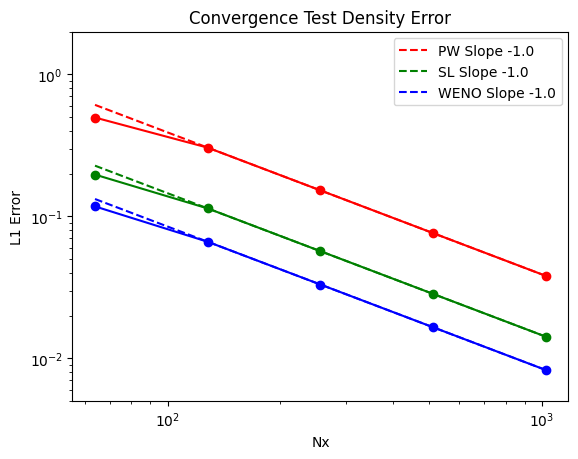

In [95]:
Uerrpw = np.zeros((len(ntest),8))
Perrpw = np.zeros((len(ntest),8))
Uerrsl = np.zeros((len(ntest),8))
Perrsl = np.zeros((len(ntest),8))
Uerrweno = np.zeros((len(ntest),8))
Perrweno = np.zeros((len(ntest),8))
for i in range(len(ntest)):
   Uerrpw[i] = statespw[i].sod_errU[statespw[i].nsteps//5:,:].mean(axis=0)
   Perrpw[i] = statespw[i].sod_errP[statespw[i].nsteps//5:,:].mean(axis=0)
   Uerrsl[i] = statessl[i].sod_errU[statessl[i].nsteps//5:,:].mean(axis=0)
   Perrsl[i] = statessl[i].sod_errP[statessl[i].nsteps//5:,:].mean(axis=0)
   Uerrweno[i] = statesweno[i].sod_errU[statesweno[i].nsteps//5:,:].mean(axis=0)
   Perrweno[i] = statesweno[i].sod_errP[statesweno[i].nsteps//5:,:].mean(axis=0)

itp = 0 #index of variable to plot
itf = 2 #starting index in n
powtpw=-1.0
powtsl = -1.0
powtweno = -1.0
colors = ['r','g','b']
errtestpw = Uerrpw[itf,itp]*(ntest/ntest[itf])**powtpw
errtestsl = Uerrsl[itf,itp]*(ntest/ntest[itf])**powtsl
errtestweno = Uerrweno[itf,itp]*(ntest/ntest[itf])**powtweno
plt.figure()
plt.loglog(ntest,Uerrpw[:,itp],'-o',color=colors[0])#,label='PW rho Error'
plt.loglog(ntest,errtestpw,'--',color=colors[0],label=f'PW Slope {powtpw}')
plt.loglog(ntest,Uerrsl[:,itp],'-o',color=colors[1])#,label='SL rho Error'
plt.loglog(ntest,errtestsl,'--',color=colors[1],label=f'SL Slope {powtsl}')
plt.loglog(ntest,Uerrweno[:,itp],'-o',color=colors[2])#,label='WENO rho Error'
plt.loglog(ntest,errtestweno,'--',color=colors[2],label=f'WENO Slope {powtweno}')
plt.legend()
plt.loglog()
plt.xlabel('Nx')
plt.ylabel('L1 Error')
plt.title(f'Convergence Test Density Error')
plt.ylim([5e-3,2e0])



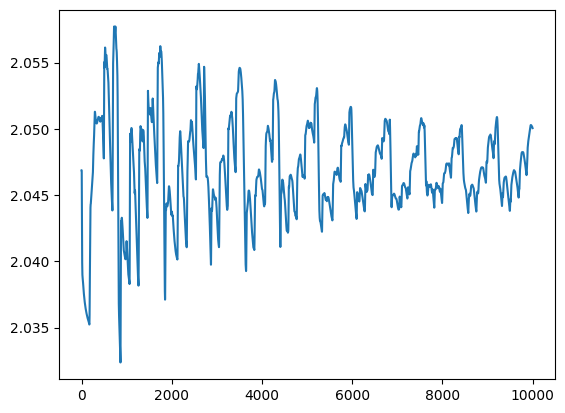

In [8]:
plt.plot(np.sum(state.Pvecs[:,6,:],axis=1)*state.dx)

In [13]:
state.Uvecs[0,4]

array([0.775, 0.775, 0.775, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125, 2.125,
       2.125, 2.125,

In [42]:
state.diagnostics[:,7]

array([6400.        , 3276.3280669 , 2267.31373425, 1772.59767625,
       1486.63456026, 1289.29259272, 1141.37415654, 1027.37927522,
        939.09555146,  871.74474593,  821.96494198,  785.1490903 ,
        755.73790005,  729.33229988,  704.32000048,  680.80998582,
        658.24005042,  635.97437503,  614.55688136,  595.73113403,
        580.68561064,  568.64015855,  557.57214099,  546.28566452,
        535.17118211,  524.89445612])

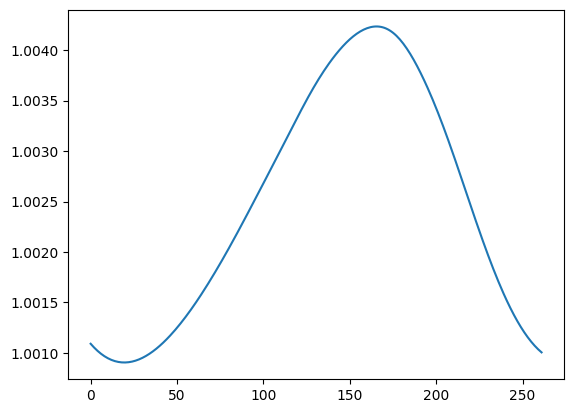

In [20]:
#it=0
#it+=100
plt.plot(state.Uvec[0,:])

In [292]:
state.cs2vec

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float64)

(-0.05, 0.05)

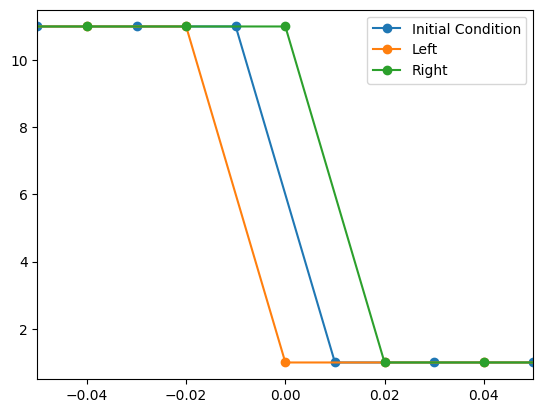

In [66]:
state.Uvecs[0,0,:]
state.weno_eps = 1e-7
def LRreconV_weno4(vvecf, vvecintLf, vvecintRf):
    gf_Imm = vvecf[:, state.ng-3:-(state.ng+1)]  # v_{i-3}
    gf_Im = vvecf[:, state.ng-2:-(state.ng)]   # v_{i-2}
    gf_I = vvecf[:, state.ng-1:-(state.ng-1)]
    gf_Ip = vvecf[:, state.ng:state.outeri]     # v_{i+1}
    gf_Ipp = vvecf[:, state.ng+1:state.outeri3]  # v_{i+2}

    betaZ0 = (13/12) * (gf_Imm - 2*gf_Im + gf_I)**2 \
        + (1/4) * (gf_Imm - 4*gf_Im + 3*gf_I)**2
    betaZ1 = (13/12) * (gf_Im - 2*gf_I + gf_Ip)**2 \
        + (1/4) * (gf_Im - gf_Ip)**2
    betaZ2  = (13/12) * (gf_I - 2*gf_Ip + gf_Ipp)**2 \
        + (1/4) * (3*gf_I - 4*gf_Ip + gf_Ipp)**2
    tau5 = np.abs(betaZ0 - betaZ2)
    aux_alphaZ0 = 1.0 + tau5 /  (state.weno_eps + betaZ0)
    aux_alphaZ1 = 6.0 + tau5 /  (state.weno_eps + betaZ1)
    aux_alphaZ2 = 3.0 + tau5 /  (state.weno_eps + betaZ2)
    weight = np.array([3.0, 6.0, 1.0])/10.0
    alphaZ0m = aux_alphaZ0 * weight[0]
    alphaZ1m = aux_alphaZ1 * weight[1]
    alphaZ2m = aux_alphaZ2 * weight[2]
    alphaZ0p = aux_alphaZ0 * weight[2]
    alphaZ1p = aux_alphaZ1 * weight[1]
    alphaZ2p = aux_alphaZ2 * weight[0]
    sum_alphaZm = alphaZ0m + alphaZ1m + alphaZ2m
    sum_alphaZp = alphaZ0p + alphaZ1p + alphaZ2p
    omegaZ0m = alphaZ0m / sum_alphaZm
    omegaZ1m = alphaZ1m / sum_alphaZm   
    omegaZ2m = alphaZ2m / sum_alphaZm
    omegaZ0p = alphaZ0p / sum_alphaZp
    omegaZ1p = alphaZ1p / sum_alphaZp
    omegaZ2p = alphaZ2p / sum_alphaZp
    vvecintLf[...] = ((omegaZ2m / 6.0) * (2.0 * gf_Ipp - 7.0 * gf_Ip + 11.0 * gf_I) +\
                     (omegaZ1m / 6.0) * (-1.0 * gf_Ip + 5.0 * gf_I + 2.0 * gf_Im)  +\
                     (omegaZ0m / 6.0) * (2.0 * gf_I + 5.0 * gf_Im - 1.0 * gf_Imm))[:, 1:]
    vvecintRf[...] = ((omegaZ0p / 6.0) * (2.0 * gf_Imm - 7.0 * gf_Im + 11.0 * gf_I) +\
                     (omegaZ1p / 6.0) * (-1.0 * gf_Im + 5.0 * gf_I + 2.0 * gf_Ip) +\
                     (omegaZ2p / 6.0) * (2.0 * gf_I + 5.0 * gf_Ip - 1.0 * gf_Ipp))[:, :-1]
    
    
#LRreconV_weno4(state.Pvecs[0,], state.PvecintL, state.PvecintR)

plt.plot(state.xg, state.Pvecs[0,4,:],'-o', label='Initial Condition')
plt.plot(state.xgi, state.PvecintL[4,:],'-o', label='Left')
plt.plot(state.xgi, state.PvecintR[4,:],'-o', label='Right')
plt.legend()
plt.xlim(-0.05,0.05)

In [ ]:
state.hardreset_state()
state.apply_ics()
state.step_in_time()
state.apply_bcsU(state.Uvec,state.Pvec)
state.dt *= 0.01
state.diffstepmax = 1e4
state.diff_update()
state.differr

np.float64(3.9466181430564425e-10)

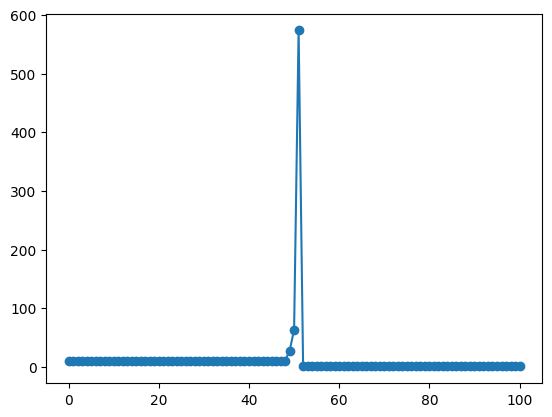

In [44]:
plt.plot(state.PvecintL[4,:],'-o')

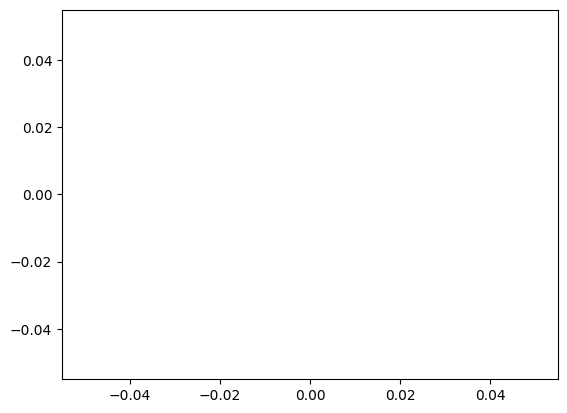

In [312]:
#it = 0
it += 1
plt.plot(state.xg,state.Pvecs[it,0,:])
#plt.ylim(np.min(state.Pvecs[0,0,:])*0.9999,np.max(state.Pvecs[0,0,:])*1.0001)

Text(0.5, 1.0, 'Density Reconstruction at Interfaces, it = 60')

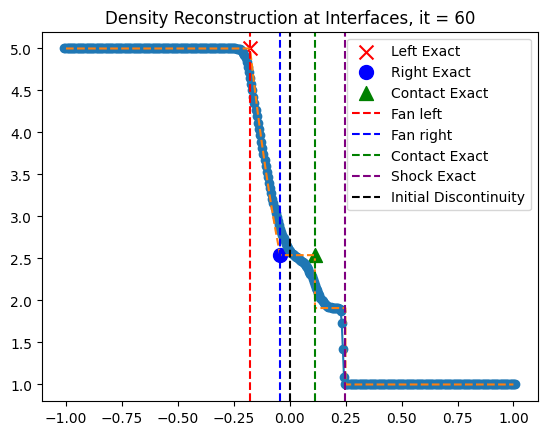

In [35]:
#it=0
it+=10
plt.plot(state.xg,state.Uvecs[it,0,:], "-o")
plt.plot(state.xghr,state.Uvecexacts[it,0,:],"--")
xintL = 0 - state.csL*state.ts[it]
xintR1 = state.vFanright*state.ts[it]
xintR2 = 0 + state.vContact*state.ts[it]
xintR3 = state.vShock*state.ts[it]
plt.scatter(xintL,state.rhoPv0[0],color='red',s=100,marker='x',label='Left Exact')
plt.scatter(xintR1,state.rho3,color='blue',s=100,marker='o',label='Right Exact')
plt.scatter(xintR2,state.rho3,color='green',s=100,marker='^',label='Contact Exact')
plt.axvline(x=xintL,color='red',linestyle='--',label = "Fan left")
plt.axvline(x=xintR1,color='blue',linestyle='--',label='Fan right')
plt.axvline(x=xintR2,color='green',linestyle='--',label='Contact Exact')
plt.axvline(x=xintR3,color='purple',linestyle='--',label='Shock Exact')
plt.axvline(x= 0,color='black',linestyle='--',label='Initial Discontinuity')
#plt.axhline(y = state.rho3)
#plt.axhline(y = state.rho4)

#plt.axhline
plt.legend()
#plt.plot(state.xgi,state.UvecintL[0,:],"-x",label='Left')
#plt.plot(state.xgi,state.UvecintR[0,:],'o',label='Right')
#plt.legend()
#plt.xlim(-0.05,0.05)
##plt.ylim(0.988,0.9924)
plt.title(f'Density Reconstruction at Interfaces, it = {it}')

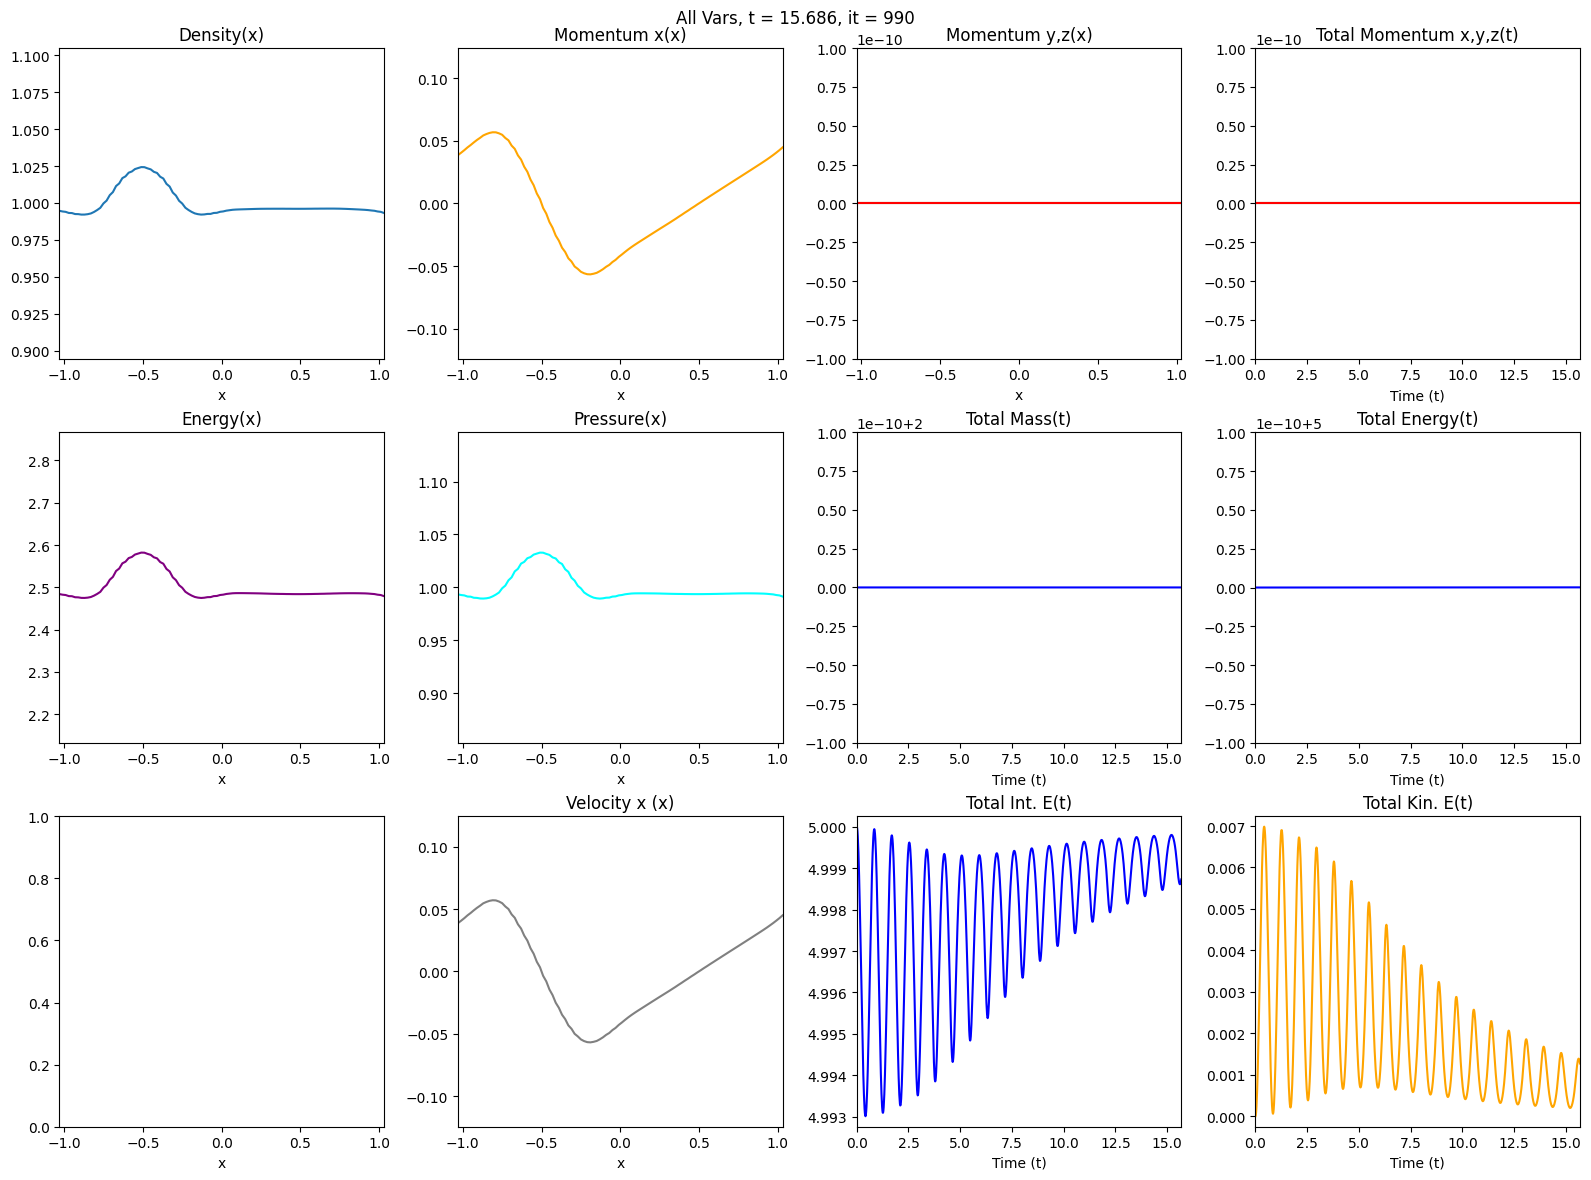

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML



frames=100
framestep = 10;
framei = np.arange(frames)*framestep
fstopt = framei[-1]+1
save = True;
if framei[-1] > state.nsteps-1:
   raise ValueError("Too many frames for number of timesteps.")

if state.boolmag:
   nplots = 16
   nrows = 4
else:
   nplots = 12
   nrows = 3
fig, axs = plt.subplots(nrows, 4, figsize=(16, nplots))
suptitle = fig.suptitle(f"All Vars, t = {state.ts[framei[0]]}, it = {framei[0]}", fontsize=12)

delfix = 1e-10 
means = state.Uvecs.mean(axis = (0,2)) #
stds = state.Uvecs.std(axis = (0,2)) #
#ymins = means - 2*stds - delfix; ymaxs = means + 2*stds + delfix;
ymins = np.min(state.Uvecs[:fstopt,:,:],axis=(0,2)) - delfix - stds/6; ymaxs = np.max(state.Uvecs[:fstopt,:,:],axis=(0,2)) + delfix + stds/6;

meansdiags = state.diagnostics.mean(axis=0)
stdsdiags = state.diagnostics.std(axis=0)
#yminsdiags = meansdiags - 2*stdsdiags - delfix; ymaxsdiags = meansdiags + 2*stdsdiags + delfix;
yminsdiags = np.min(state.diagnostics[:fstopt,:],axis=0) - delfix - stdsdiags/6; ymaxsdiags = np.max(state.diagnostics[:fstopt,:],axis=0) + delfix + stdsdiags/6;

meansprims = state.Pvecs.mean(axis=(0,2))
stdsprims = state.Pvecs.std(axis=(0,2))
#yminsaux = meansaux - 2*stdsaux - delfix; ymaxsaux = meansaux + 2*stdsaux + delfix;
yminsprims = np.min(state.Pvecs[:fstopt,:,:],axis=(0,2)) - delfix - stdsprims/6; ymaxsprims = np.max(state.Pvecs[:fstopt,:,:],axis=(0,2)) + delfix + stdsprims/6;
#Animation 4x4 plots. (rho, rhovx,rhovy/rhovz, total rhovx/rhovy/rhovz), (E,m, total energy, total mass), (P, KE, total P/gamma-1, total KE),
# (By,Bz, MagE, total MagE). Totals are animated lines moving to the right in time.
# to fix in case of zero std
if True:
   line1rho = axs[0,0].plot([],[],label='Density')[0]
   if state.ici == 0:
      line1rhoexact = axs[0,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line2rhovxexact = axs[0,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line5rhovxtotexact = axs[0,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line8Eexact = axs[1,0].plot([],[],label='Exact',color='black',ls='--')[0]
      line9Pexact = axs[1,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line10massexact = axs[1,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line11Etexact = axs[1,3].plot([],[],label='Exact',color='black',ls='--')[0]
      line12KEexact = axs[2,1].plot([],[],label='Exact',color='black',ls='--')[0]
      line13utotexact = axs[2,2].plot([],[],label='Exact',color='black',ls='--')[0]
      line14KEtotexact = axs[2,3].plot([],[],label='Exact',color='black',ls='--')[0]
   line2rhovx = axs[0,1].plot([],[],label='Momentum x',color='orange')[0]
   line3rhovy = axs[0,2].plot([],[],label='Momentum y',color='green')[0]
   line4rhovz = axs[0,2].plot([],[],label='Momentum z',color='red')[0]
   line5rhovxtot = axs[0,3].plot([],[],label='Total Momentum x',color='blue')[0]
   line6rhovytot = axs[0,3].plot([],[],label='Total Momentum y',color='green')[0]
   line7rhovztot = axs[0,3].plot([],[],label='Total Momentum z',color='red')[0]


   line8E = axs[1,0].plot([],[],label='Energy',color='purple')[0]
   line9P = axs[1,1].plot([],[],label='Pressure',color='cyan')[0]
   line10mass = axs[1,2].plot([],[],label='Mass',color='blue')[0]
   line11Etot = axs[1,3].plot([],[],label='Total Energy',color='blue')[0]


   line12vx = axs[2,1].plot([],[],label='Velocity x',color='grey')[0]
   line13utot = axs[2,2].plot([],[],label='Total internal Energy',color='blue')[0]
   line14KEtot = axs[2,3].plot([],[],label='Total Kinetic Energy',color='orange')[0]


   if state.boolmag:
      line15By = axs[3,0].plot([],[],label='By',color='brown')[0]
      line16Bz = axs[3,1].plot([],[],label='Bz',color='pink')[0]
      line17ME = axs[3,2].plot([],[],label='Magnetic Energy',color='black')[0]
      line18MEtot = axs[3,3].plot([],[],label='Total Magnetic Energy',color='blue')[0]

   axs[0,0].set_ylim(ymins[0],ymaxs[0])#rho
   axs[0,1].set_ylim(ymins[1],ymaxs[1])#rhovx
   axs[0,2].set_ylim(ymins[2],ymaxs[2])#rhovy
   axs[0,3].set_ylim(yminsdiags[3],ymaxsdiags[3])#total rhovx

   axs[1,0].set_ylim(ymins[4],ymaxs[4])#E
   axs[1,1].set_ylim(yminsprims[4],ymaxsprims[4])#P
   axs[1,2].set_ylim(yminsdiags[0],ymaxsdiags[0])#total mass
   axs[1,3].set_ylim(yminsdiags[1],ymaxsdiags[1])#total energy

   axs[2,1].set_ylim(yminsprims[1],ymaxsprims[1])#velocity 
   axs[2,2].set_ylim(yminsdiags[2],ymaxsdiags[2])#total internal energy
   
   axs[2,3].set_ylim(yminsdiags[10],ymaxsdiags[10])#total kinetic energy
   if state.boolmag:
      axs[3,0].set_ylim(ymins[5],ymaxs[5])#By
      axs[3,1].set_ylim(ymins[6],ymaxs[6])#Bz
      axs[3,2].set_ylim(yminsaux[7],ymaxsaux[7])#MagE
      axs[3,3].set_ylim(yminsdiags[9],ymaxsdiags[9])#total MagE
   for idx,ax  in enumerate(axs.flat):
      if idx in [3,6,7,10,11,15]:
         ax.set_xlabel('Time (t)')
         ax.set_xlim(state.ts[framei[0]],state.ts[framei[-1]])
      else:
         ax.set_xlabel('x')
         ax.set_xlim(state.xg[0],state.xg[-1])
      # if idx in [2,3]:
      #    plt.legend()

   if state.boolmag:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot,line15By,line16Bz,line17ME,line18MEtot]
   else:
      lines = [line1rho,line2rhovx,line3rhovy,line4rhovz,line5rhovxtot,line6rhovytot,line7rhovztot,
               line8E,line9P,line10mass,line11Etot,line12vx,line13utot,line14KEtot]
   if state.ici == 0:
      lines = [*lines, line1rhoexact,line2rhovxexact,line5rhovxtotexact,
               line8Eexact,line9Pexact,line10massexact,line11Etexact,line12KEexact,line13utotexact,line14KEtotexact]

plt.tight_layout()

def init():
   titles = ['Density(x)', 'Momentum x(x)', 'Momentum y,z(x)', 'Total Momentum x,y,z(t)',
              'Energy(x)', 'Pressure(x)','Total Mass(t)', 'Total Energy(t)',
             '', 'Velocity x (x)', 'Total Int. E(t)', 'Total Kin. E(t)',
             'By(x)', 'Bz(x)', 'Magnetic Energy(x)', 'Total Magnetic Energy(t)']
   if state.boolmag:
      pass
   else:
      titles = titles[0:-4]
             
   for idx, ax in enumerate(axs.flat):
      ax.set_title(titles[idx])
   for line in lines:
      line.set_data([], [])
   return lines

def animate(frame):
   lines[0].set_data(state.xg, state.Uvecs[frame, 0, :]) #rho
   lines[1].set_data(state.xg, state.Uvecs[frame, 1, :]) #rhovx
   lines[2].set_data(state.xg, state.Uvecs[frame, 2, :]) #rhovy
   lines[3].set_data(state.xg, state.Uvecs[frame, 3, :]) #rhovz
   lines[4].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total rhovx
   lines[5].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 3]) #total rhovy
   lines[6].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 4]) #total rhovz
   lines[7].set_data(state.xg, state.Uvecs[frame, 4, :]) #E
   lines[8].set_data(state.xg, state.Pvecs[frame, 4, :]) #P
   lines[9].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 0]) #total mass
   lines[10].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 1]) #total energy
   lines[11].set_data(state.xg, state.Pvecs[frame, 1, :]) #vx
   lines[12].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 2]) #total internal energy
   lines[13].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 10]) #total kinetic energy
   if state.ici == 0:
      lines[14].set_data(state.xghr, state.Uvecexacts[frame, 0, :]) #rho exact
      lines[15].set_data(state.xghr, state.Uvecexacts[frame, 1, :]) #rhovx exact
      lines[16].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 3]) #total rhovx exact
      lines[17].set_data(state.xghr, state.Uvecexacts[frame, 4, :]) #E exact
      lines[18].set_data(state.xghr, state.Pvecexacts[frame, 4, :]) #P exact
      lines[19].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 0]) #total mass exact
      lines[20].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 1]) #total energy exact
      lines[21].set_data(state.xghr, state.Pvecexacts[frame, 1, :]) #vx exact
      lines[22].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 2]) #total internal energy exact
      lines[23].set_data(state.ts[:frame+1], state.diagnostics_exact[:frame+1, 10]) #total kinetic energy exact
   if state.boolmag:#(mass, energy, internal energy, rhovx, rhovy, rhovz, rhov, gradP, lapP, magE, KE)
      lines[14].set_data(state.xg, state.Uvecs[frame, 5, :]) #By
      lines[15].set_data(state.xg, state.Uvecs[frame, 6, :]) #Bz
      lines[16].set_data(state.xg, state.Auxvecs[frame, 7, :]) #magE
      lines[17].set_data(state.ts[:frame+1], state.diagnostics[:frame+1, 9]) #total magE
   suptitle.set_text(f"All Vars, t = {state.ts[frame]:.3f}, it = {frame}")
   return lines

anim = FuncAnimation(fig, animate, init_func=init, frames=framei, interval=35, blit=True)
HTML(anim.to_jshtml())
if save:
   anim.save(gifdir + f"anim{state.icname}.mp4", fps=15)


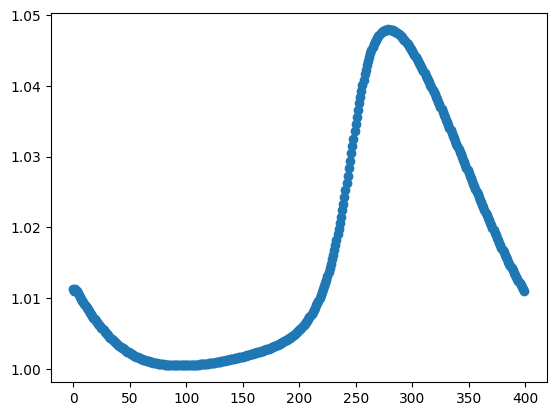

In [181]:
#it = 0
it +=10
plt.plot(state.Uvecs[it,0,:], "-o")